In [1]:
import sdm as sdmlib
import matplotlib.pyplot as plt
import time
from collections import defaultdict, OrderedDict
from IPython.display import clear_output
%matplotlib inline

In [2]:
class Timer(object):
    def __init__(self):
        self.stats = OrderedDict()
        self.current_stats = None
        
    def start(self, key, name):
        self.current_stats = {
            'name': name,
            't0_loops': [],
            't0': time.time(),
        }
        self.stats[key] = self.current_stats
        self.t0 = time.time()
        
    def measure_loop(self):
        self.current_stats['t0_loops'].append(time.time())
        
    def end(self):
        d = self.current_stats
        d['dt'] = time.time() - d['t0']
        if d['t0_loops']:
            d['number-of-loops'] = len(d['t0_loops'])
            d['loops-per-second'] = d['number-of-loops'] / d['dt']
            d['loops'] = []
            
            t0 = d['t0']
            for t1 in d['t0_loops']:
                d['loops'].append(t1-t0)
                t0 = t1
        d.pop('t0')
        d.pop('t0_loops')
        self.current_stats = None

# Part 1 - Compare scanners

In [3]:
def run_part1(bits, sample, radius, nlinear=1000, nthread=5000, nopencl=5000):
    address_space = sdmlib.AddressSpace.init_random(bits, sample)
    address_space.opencl_init();
    
    timer = Timer()

    print('Running linear scan...')
    timer.start('scan_linear', 'Linear scan')
    for i in range(nlinear):
        bs = sdmlib.Bitstring.init_random(bits)
        address_space.scan_linear2(bs, radius)
        timer.measure_loop()
    timer.end()

    timer.start('scan_thread', 'Thread scan')
    print('Running thread scan...')
    for i in range(nthread):
        bs = sdmlib.Bitstring.init_random(bits)
        address_space.scan_thread2(bs, radius)  
        timer.measure_loop()
    timer.end()
    
    timer.start('scan_opencl', 'OpenCL scan')
    print('Running OpenCL scan...')
    for i in range(nopencl):
        bs = sdmlib.Bitstring.init_random(bits)
        address_space.scan_opencl2(bs, radius)
        timer.measure_loop()
    timer.end()
    
    return timer

In [4]:
def results_part1(bits, timer):
    from IPython.display import display, Markdown
    v = [['', 'Loops', 'Total time', 'Scans per second', 'Time per scan (ms)']]
    v.append(['---', '---:', '---:', '---:', '---:'])
    for key in ['scan_linear', 'scan_thread', 'scan_opencl']:
        stats = timer.stats[key]
        v.append([
            stats['name'],
            stats['number-of-loops'],
            stats['dt'],
            stats['loops-per-second'],
            1000.0 / stats['loops-per-second'],
        ])
    txt = '\n'.join(['|'.join([str(x) for x in row]) for row in v])
    display(Markdown(txt))
    
    plt.figure(figsize=(8, 6), dpi=300)
    plt.hist([1000*x for x in timer.stats['scan_linear']['loops']], bins='fd', alpha=0.9, label='Linear scan')
    plt.hist([1000*x for x in timer.stats['scan_thread']['loops']], bins='fd', alpha=0.9, label='Thread scan')
    plt.hist([1000*x for x in timer.stats['scan_opencl']['loops']], bins='fd', alpha=0.9, label='OpenCL scan')
    plt.legend()
    plt.title('Scan performance ($n={}$ bits)'.format(bits))
    plt.xlabel('Scan duration (ms)')
    plt.ylabel('Probability')

In [5]:
timer1000 = run_part1(1000, 1000000, 451)

Running linear scan...
Running thread scan...
Running OpenCL scan...


|Loops|Total time|Scans per second|Time per scan (ms)
---|---:|---:|---:|---:
Linear scan|1000|14.156379222869873|70.6395317797423|14.156379222869873
Thread scan|5000|40.97653794288635|122.02104548141834|8.19530758857727
OpenCL scan|5000|209.11446475982666|23.91034979690491|41.82289295196533

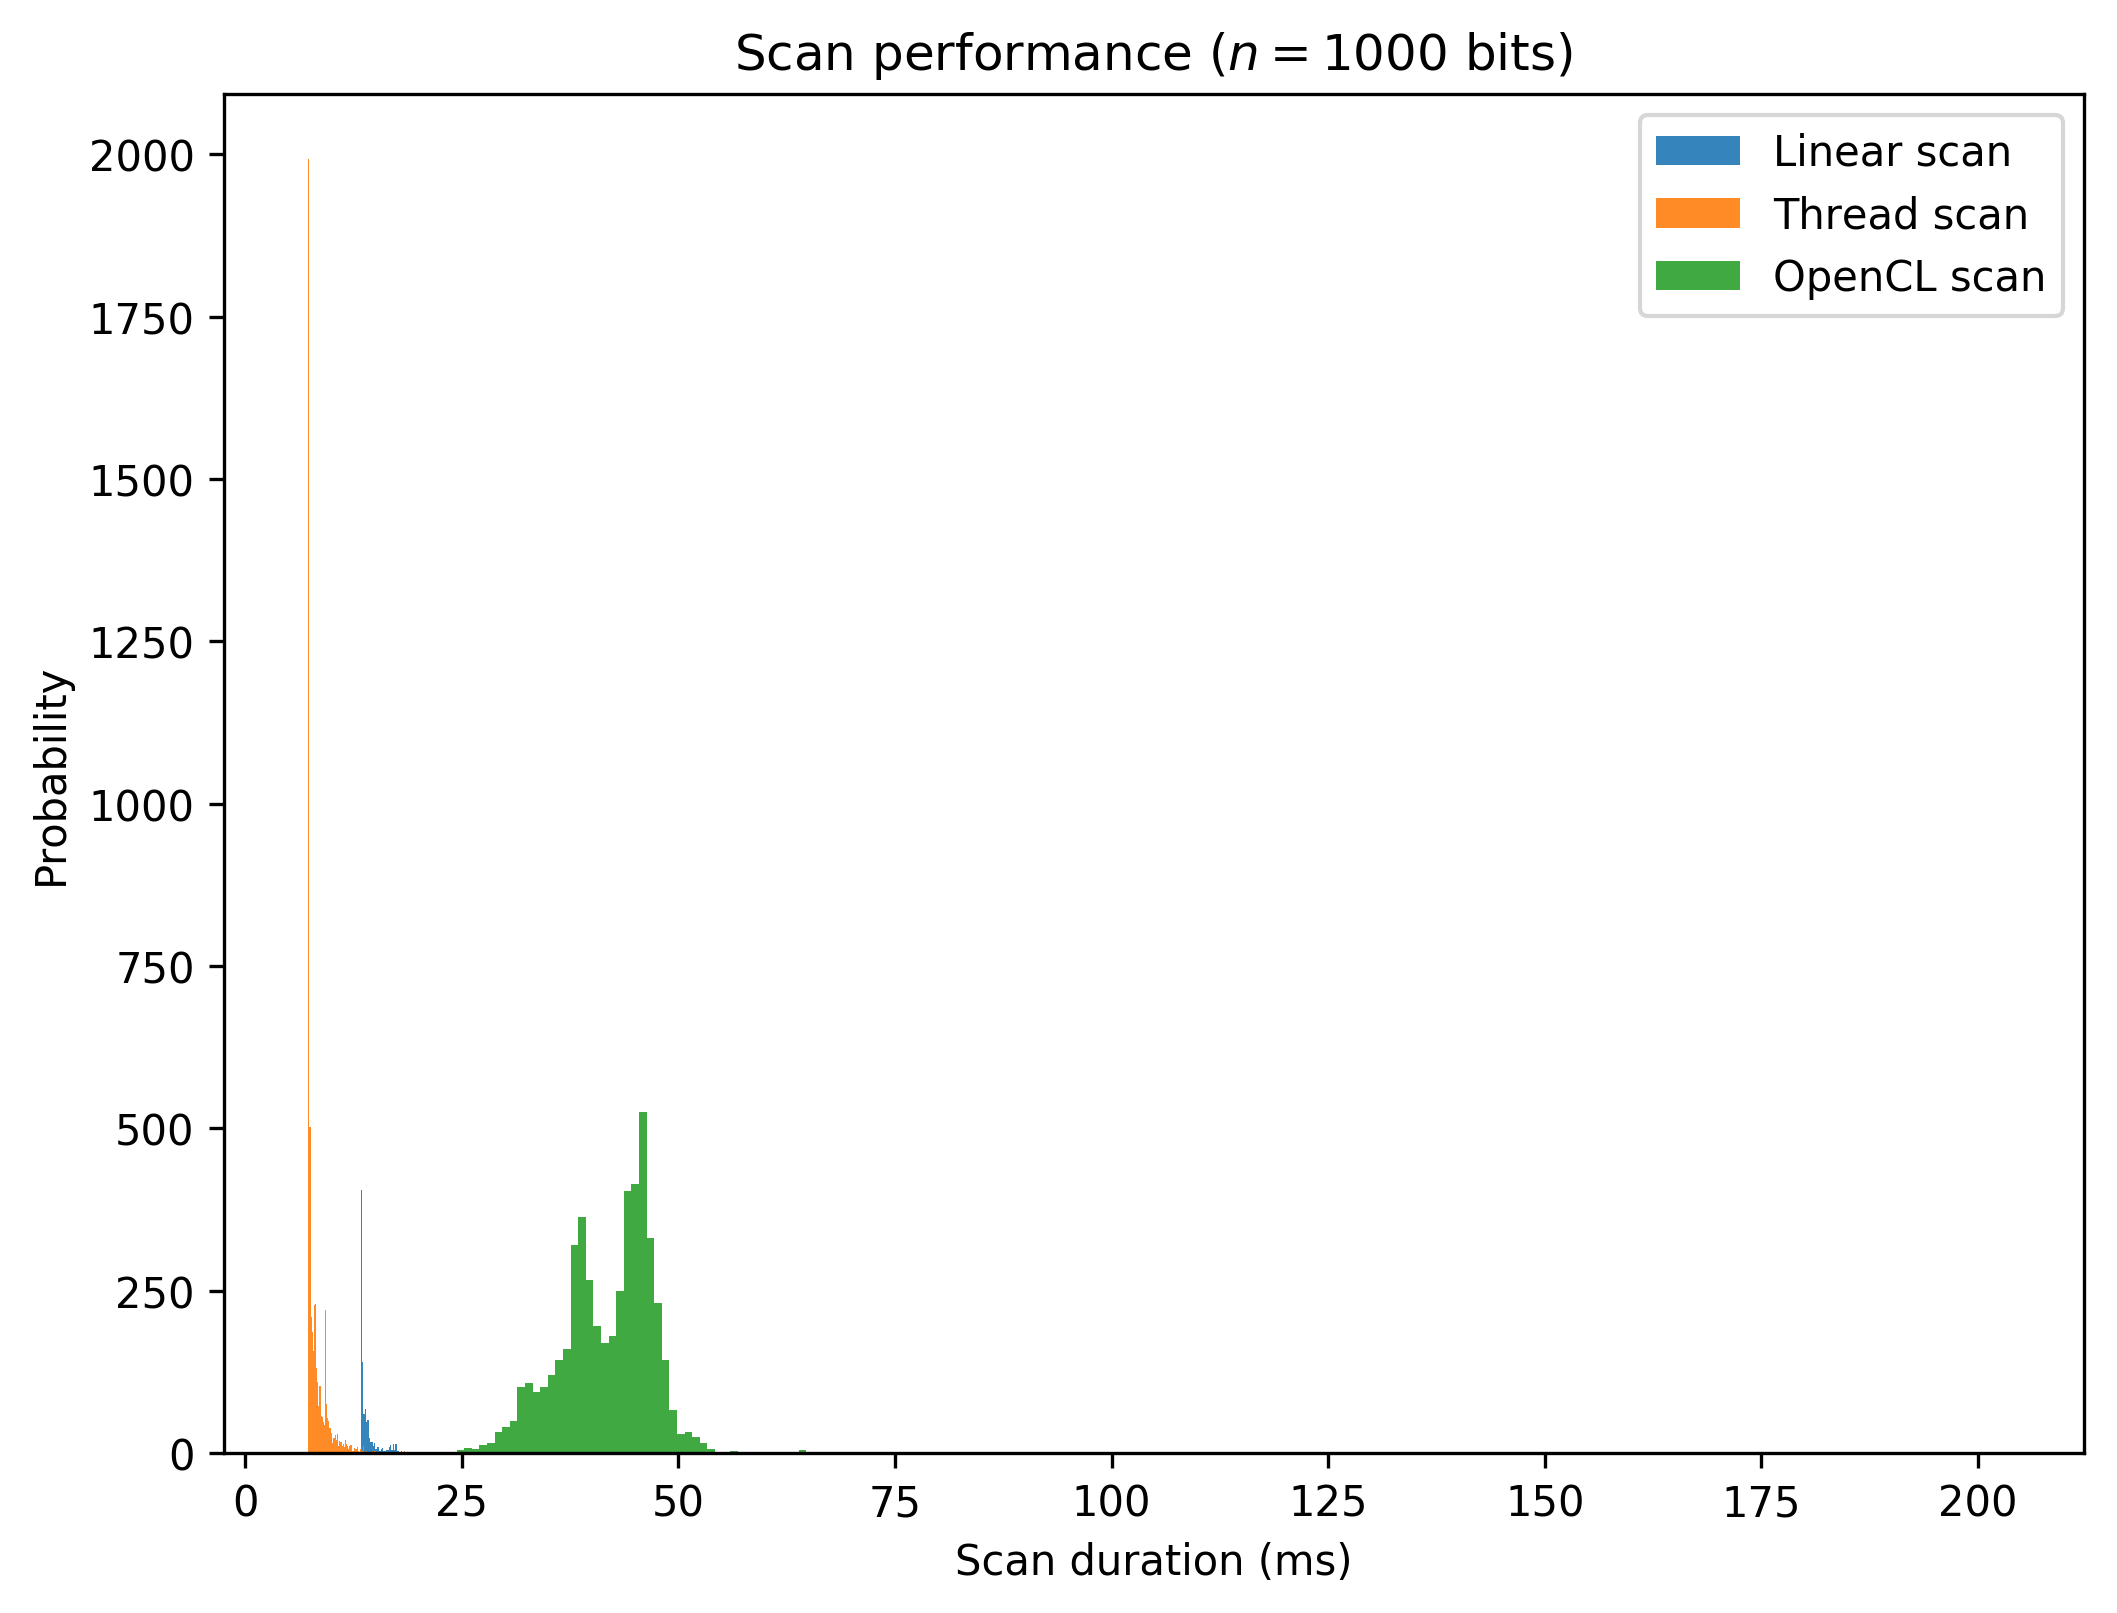

In [6]:
results_part1(1000, timer1000)

In [12]:
timer256 = run_part1(256, 1000000, 103)

Running linear scan...
Running thread scan...
Running OpenCL scan...


|Loops|Total time|Scans per second|Time per scan (ms)
---|---:|---:|---:|---:
Linear scan|1000|5.9584550857543945|167.8287384242976|5.9584550857543945
Thread scan|5000|18.238537788391113|274.14478386433564|3.6477075576782227
OpenCL scan|5000|79.90512990951538|62.574205256433515|15.981025981903075

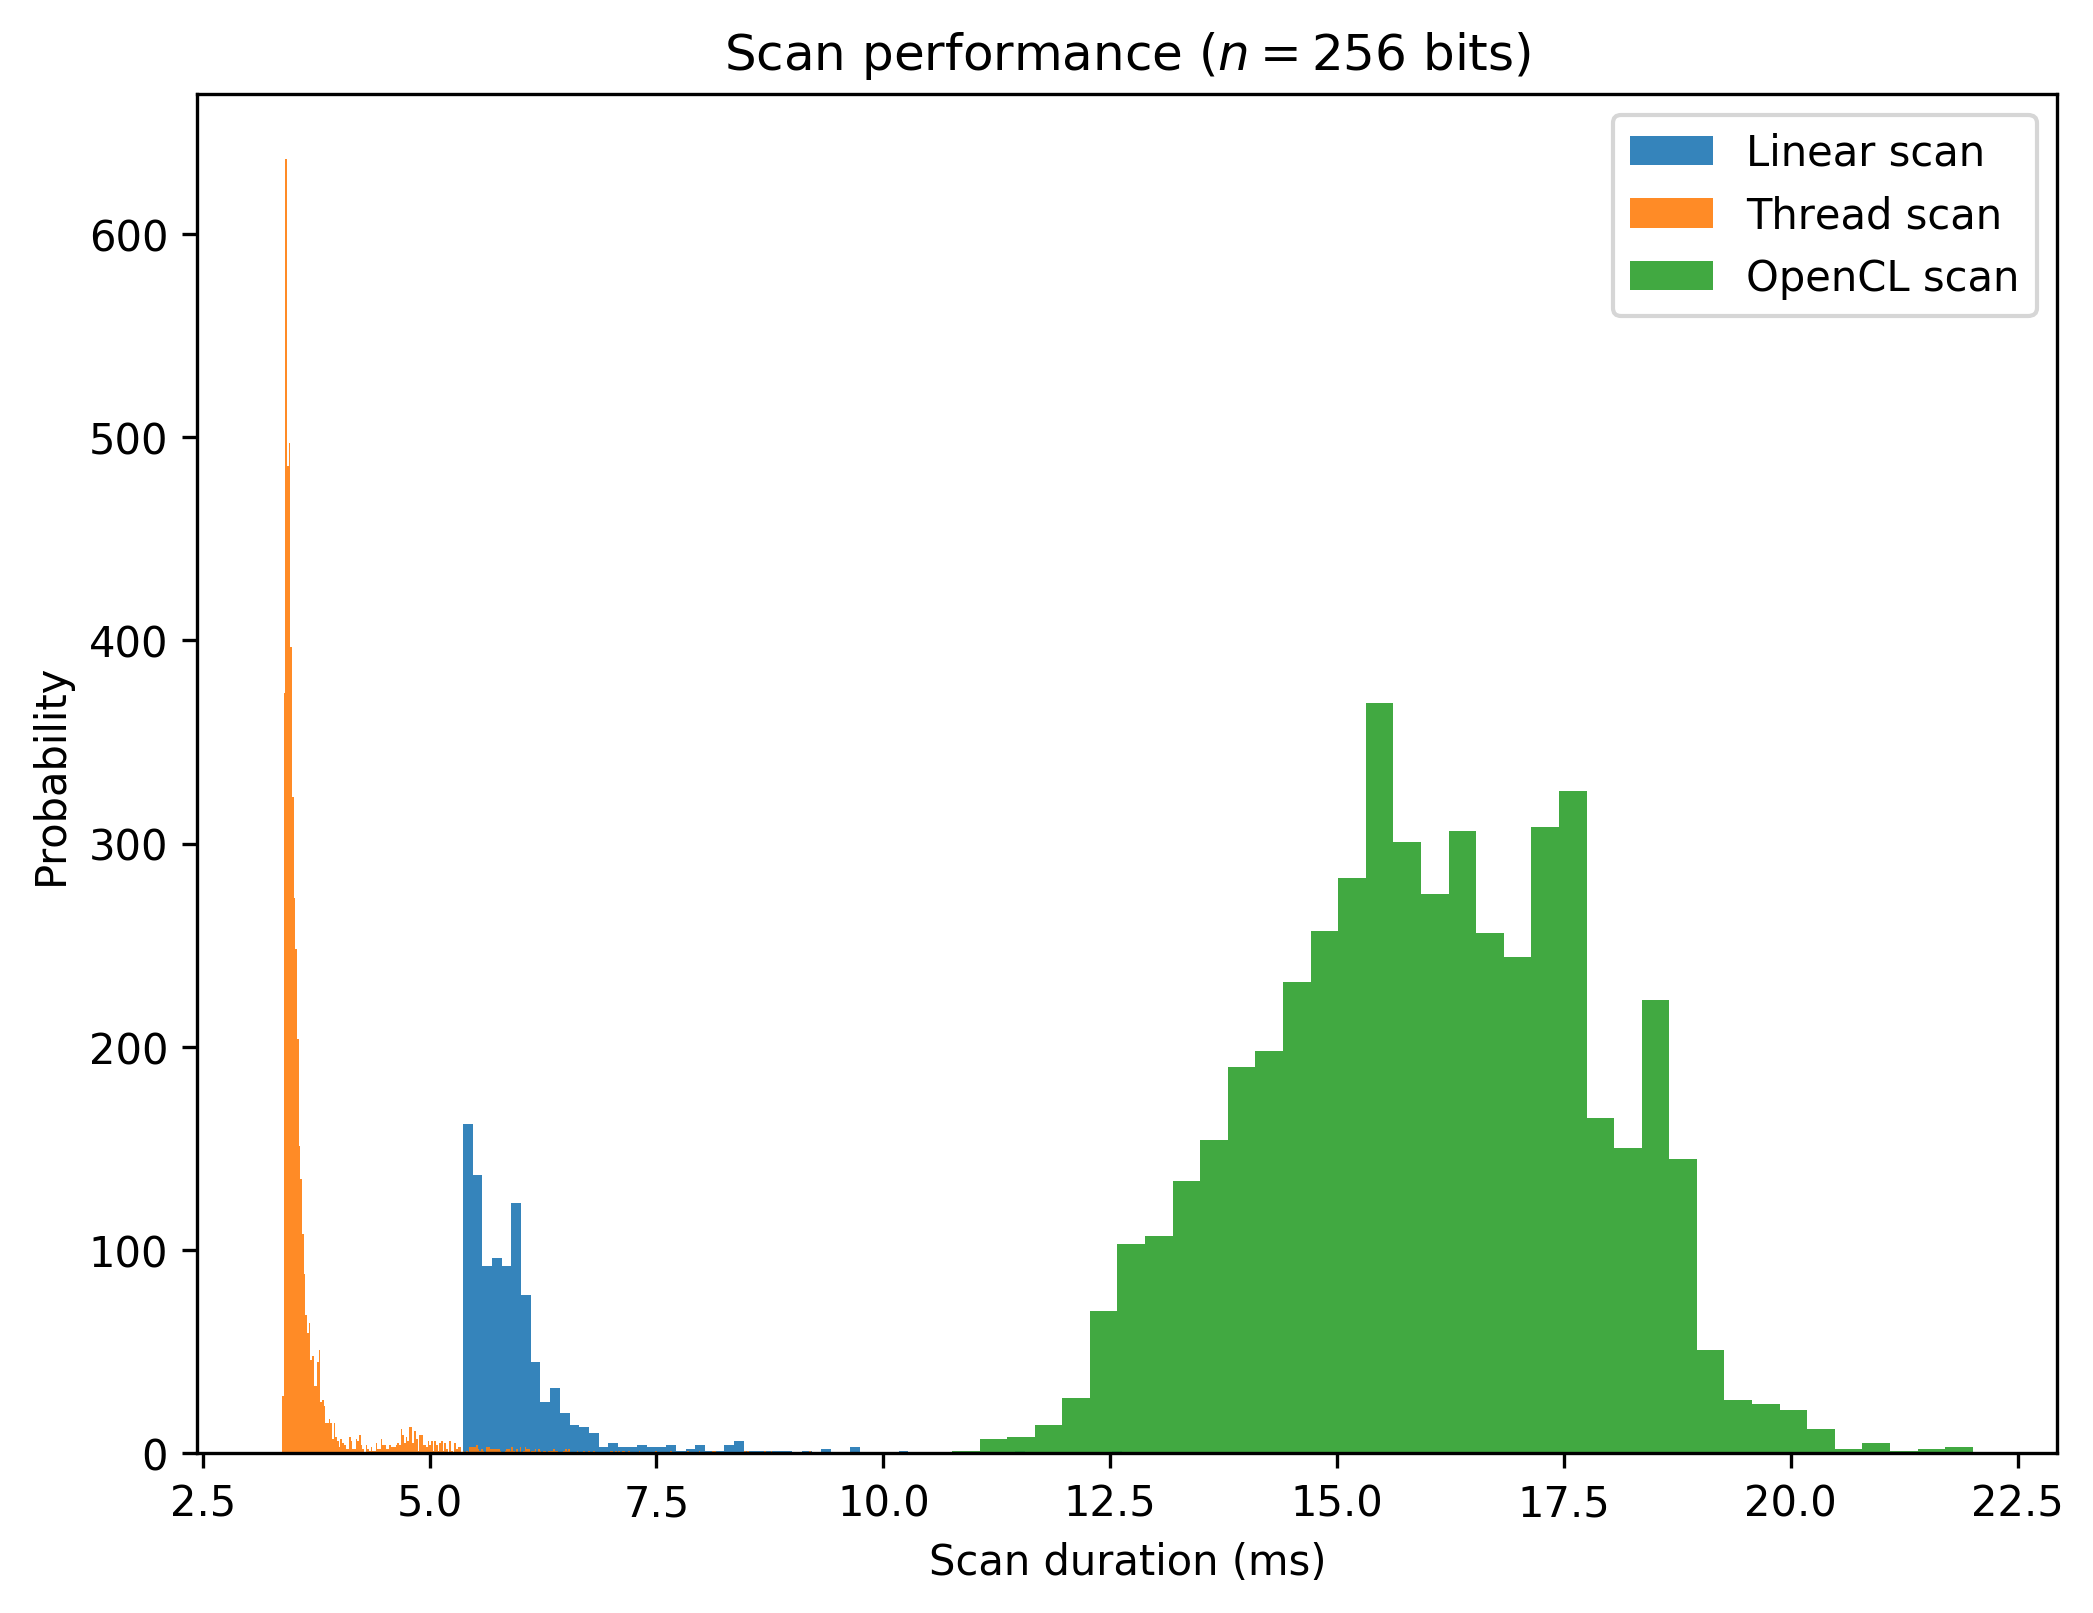

In [14]:
results_part1(256, timer256)
#plt.xlim(2.4, 7.5);

In [ ]:
timer10k = run_part1(10000, 1000000, 4845, nlinear=100, nthread=500, nopencl=1000)

In [1]:
results_part1(10000, timer10k)
plt.xlim(7, 150);

NameError: name 'results_part1' is not defined

# Part 2 - Compare scanners read/write

In [8]:
def read_write(key, name, timer, bits, sample, radius, scanner_type, n):
    address_space = sdmlib.AddressSpace.init_random(bits, sample)
    counter = sdmlib.Counter.init_zero(bits, sample)
    sdm = sdmlib.SDM(address_space, counter, radius, scanner_type)

    timer.start('write_{}'.format(key), '{} write'.format(name))
    for _ in range(n):
        bs = sdmlib.Bitstring.init_random(bits)
        sdm.write(bs, bs)
        timer.measure_loop()
    timer.end()
    
    timer.start('read_{}'.format(key), '{} single read'.format(name))
    for _ in range(n):
        bs = sdmlib.Bitstring.init_random(bits)
        sdm.read(bs)
        timer.measure_loop()
    timer.end()
    
    return timer

In [9]:
def run_part2(bits, sample, radius, nthread=1000, nopencl=1000):
    timer = Timer()
    print ('Running thread...')
    read_write('thread', 'Thread', timer, bits, sample, radius, sdmlib.SDM_SCANNER_THREAD, n=nthread)
    print ('Running OpenCL...')
    read_write('opencl', 'OpenCL', timer, bits, sample, radius, sdmlib.SDM_SCANNER_OPENCL, n=nopencl)
    return timer

In [10]:
def results_part2(bits, timer, hist_xlim=None):
    from IPython.display import display, Markdown
    v = [['', 'Loops', 'Total time', 'Operation per second', 'Time per operation (ms)']]
    v.append(['---', '---:', '---:', '---:', '---:'])
    for key in timer.stats.keys():
        stats = timer.stats[key]
        v.append([
            stats['name'],
            stats['number-of-loops'],
            stats['dt'],
            stats['loops-per-second'],
            1000.0 / stats['loops-per-second'],
        ])
    txt = '\n'.join(['|'.join([str(x) for x in row]) for row in v])
    display(Markdown(txt))

    plt.figure(figsize=(8, 6), dpi=300)
    for key in ['write_thread', 'write_opencl']:
        stats = timer.stats[key]
        plt.hist([1000*x for x in stats['loops']], bins='fd', alpha=0.9, label=stats['name'])
    plt.legend()
    plt.title('Write performance ($n={}$ bits)'.format(bits))
    plt.xlabel('Scan duration (ms)')
    plt.ylabel('Probability')
    if hist_xlim:
        plt.xlim(*hist_xlim)
    plt.show()
    
    plt.figure(figsize=(8, 6), dpi=300)
    for key in ['read_thread', 'read_opencl']:
        stats = timer.stats[key]
        plt.hist([1000*x for x in stats['loops']], bins='fd', alpha=0.9, label=stats['name'])
    plt.legend()
    plt.title('Read performance ($n={}$ bits)'.format(bits))
    plt.xlabel('Scan duration (ms)')
    plt.ylabel('Probability')
    if hist_xlim:
        plt.xlim(*hist_xlim)

In [12]:
p2timer1000 = run_part2(1000, 1000000, 451, nthread=1000, nopencl=1000)

Running thread...
Running OpenCL...


|Loops|Total time|Operation per second|Time per operation (ms)
---|---:|---:|---:|---:
Thread write|1000|9.787221193313599|102.1740471834004|9.787221193313599
Thread single read|1000|8.104193925857544|123.3929011507687|8.104193925857544
OpenCL write|1000|20.622983932495117|48.489588280400355|20.622983932495117
OpenCL single read|1000|12.687389135360718|78.81842271337953|12.68738913536072

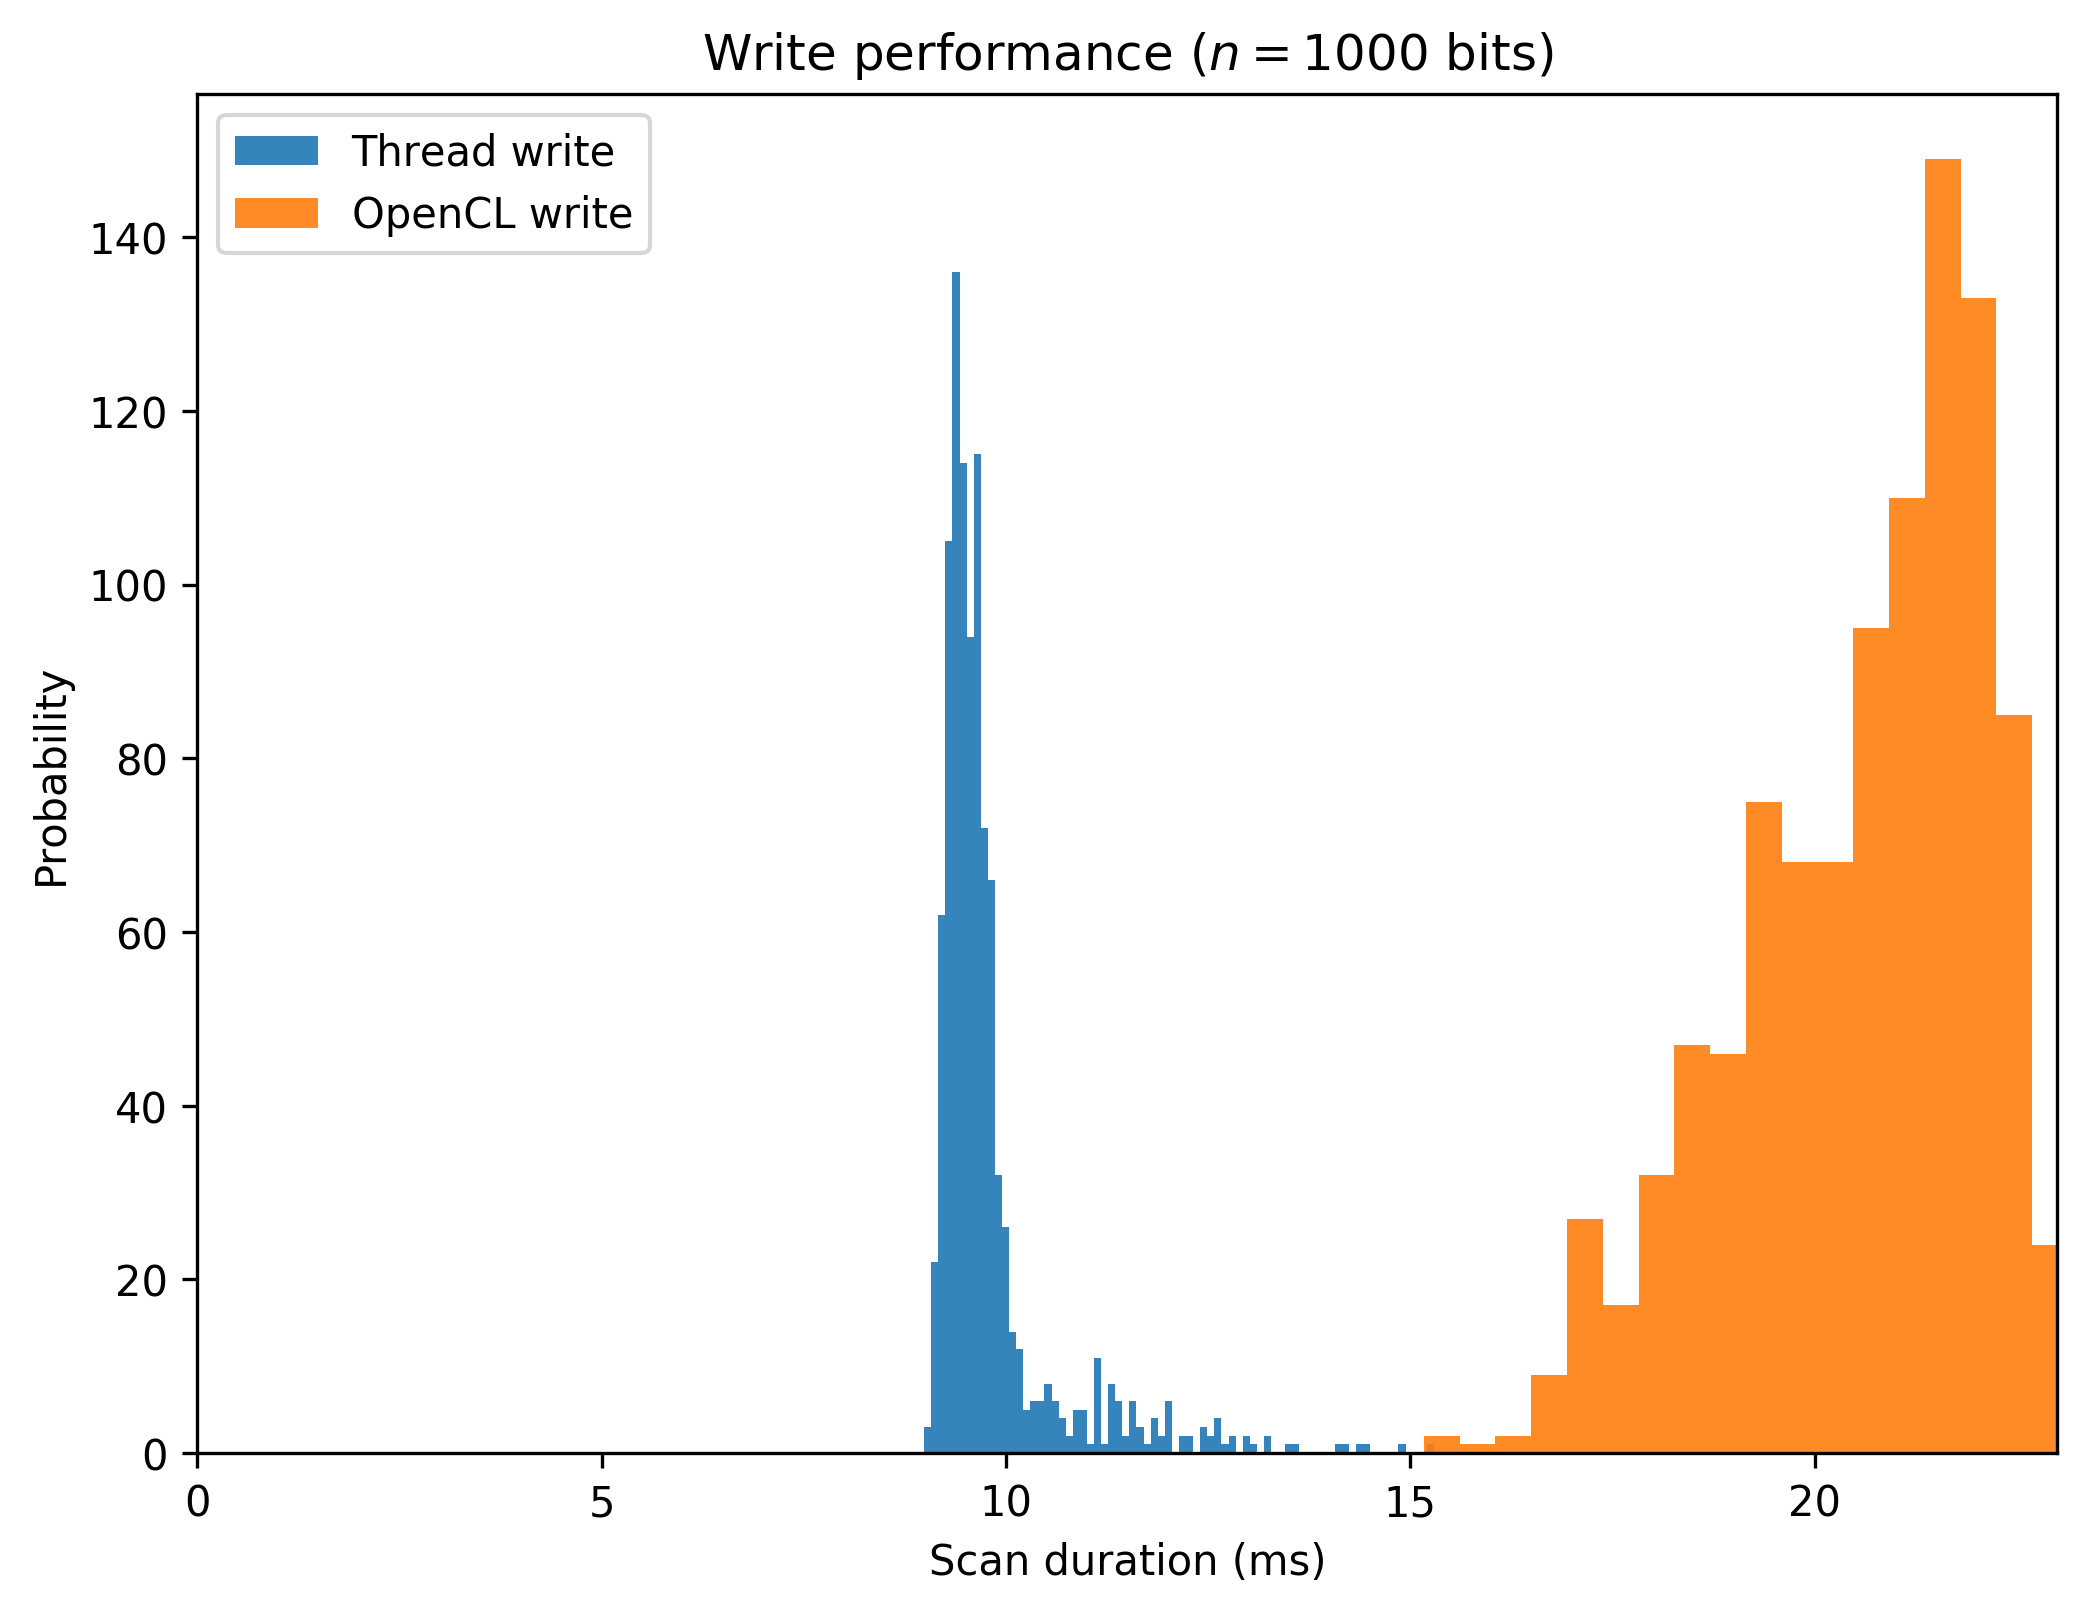

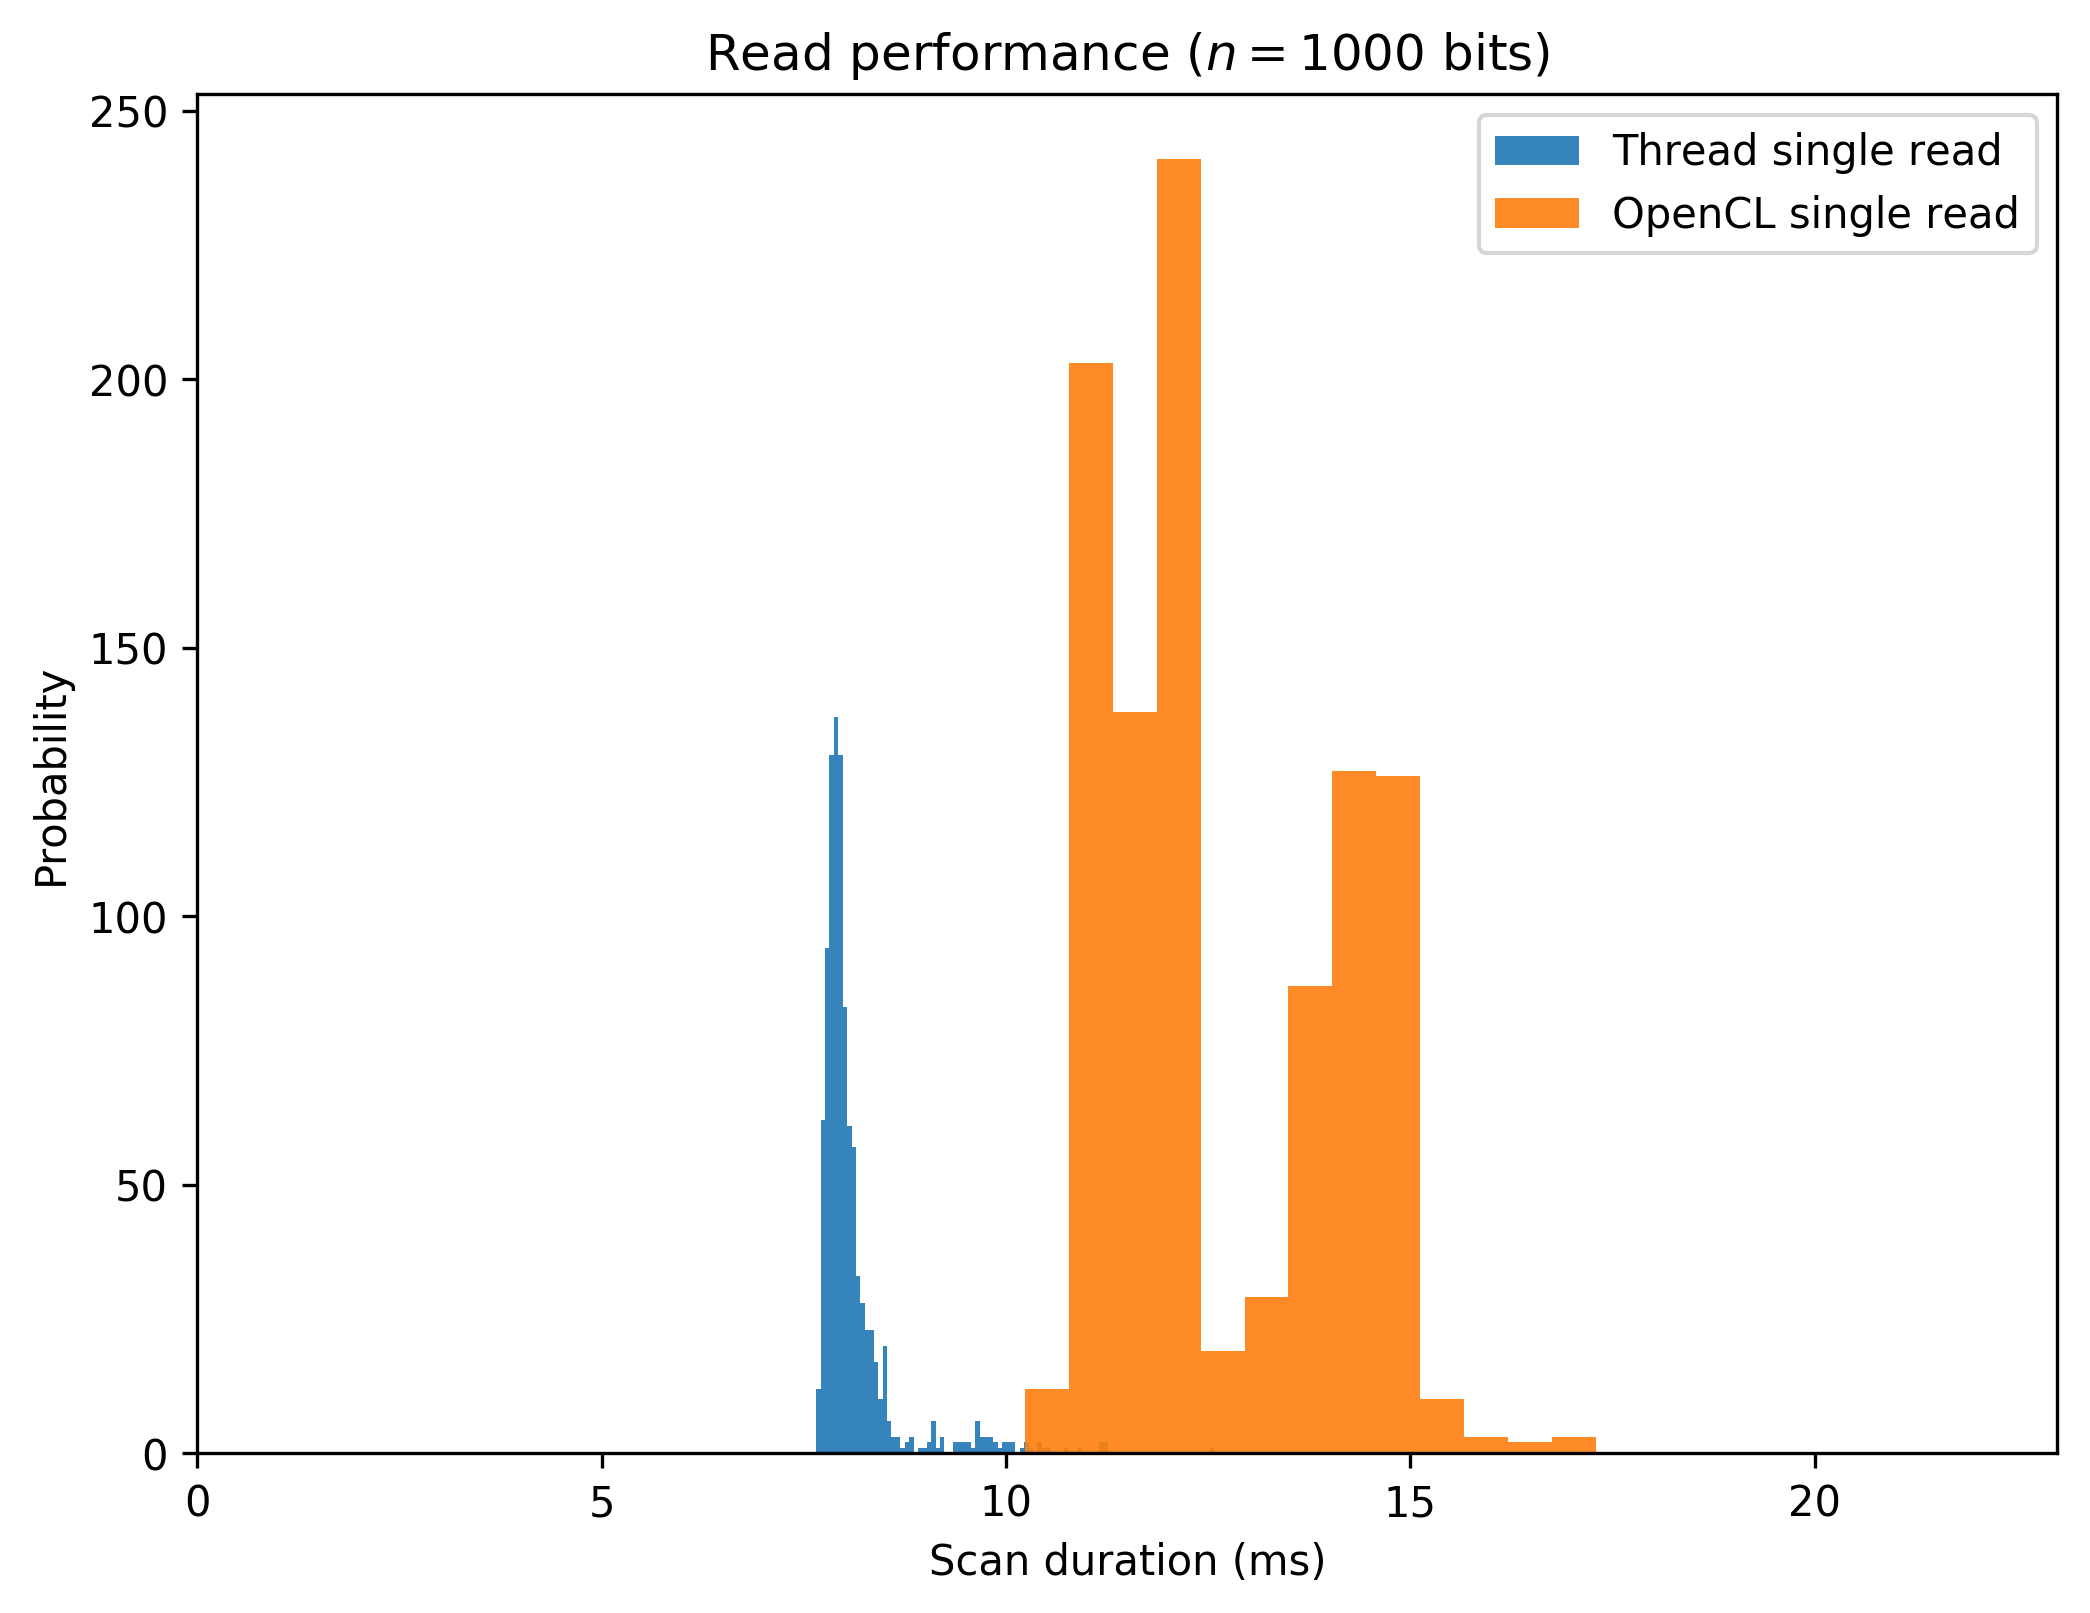

In [13]:
results_part2(1000, p2timer1000, hist_xlim=(0, 23))

In [11]:
p2timer256 = run_part2(256, 1000000, 103, nthread=2000, nopencl=2000)

Running thread...
Running OpenCL...


|Loops|Total time|Operation per second|Time per operation (ms)
---|---:|---:|---:|---:
Thread write|2000|7.413758993148804|269.7686830457044|3.7068794965744014
Thread single read|2000|6.635550022125244|301.40681531015525|3.317775011062622
OpenCL write|2000|69.85624814033508|28.630223541095067|34.92812407016754
OpenCL single read|2000|57.077149868011475|35.04029203674179|28.538574934005734

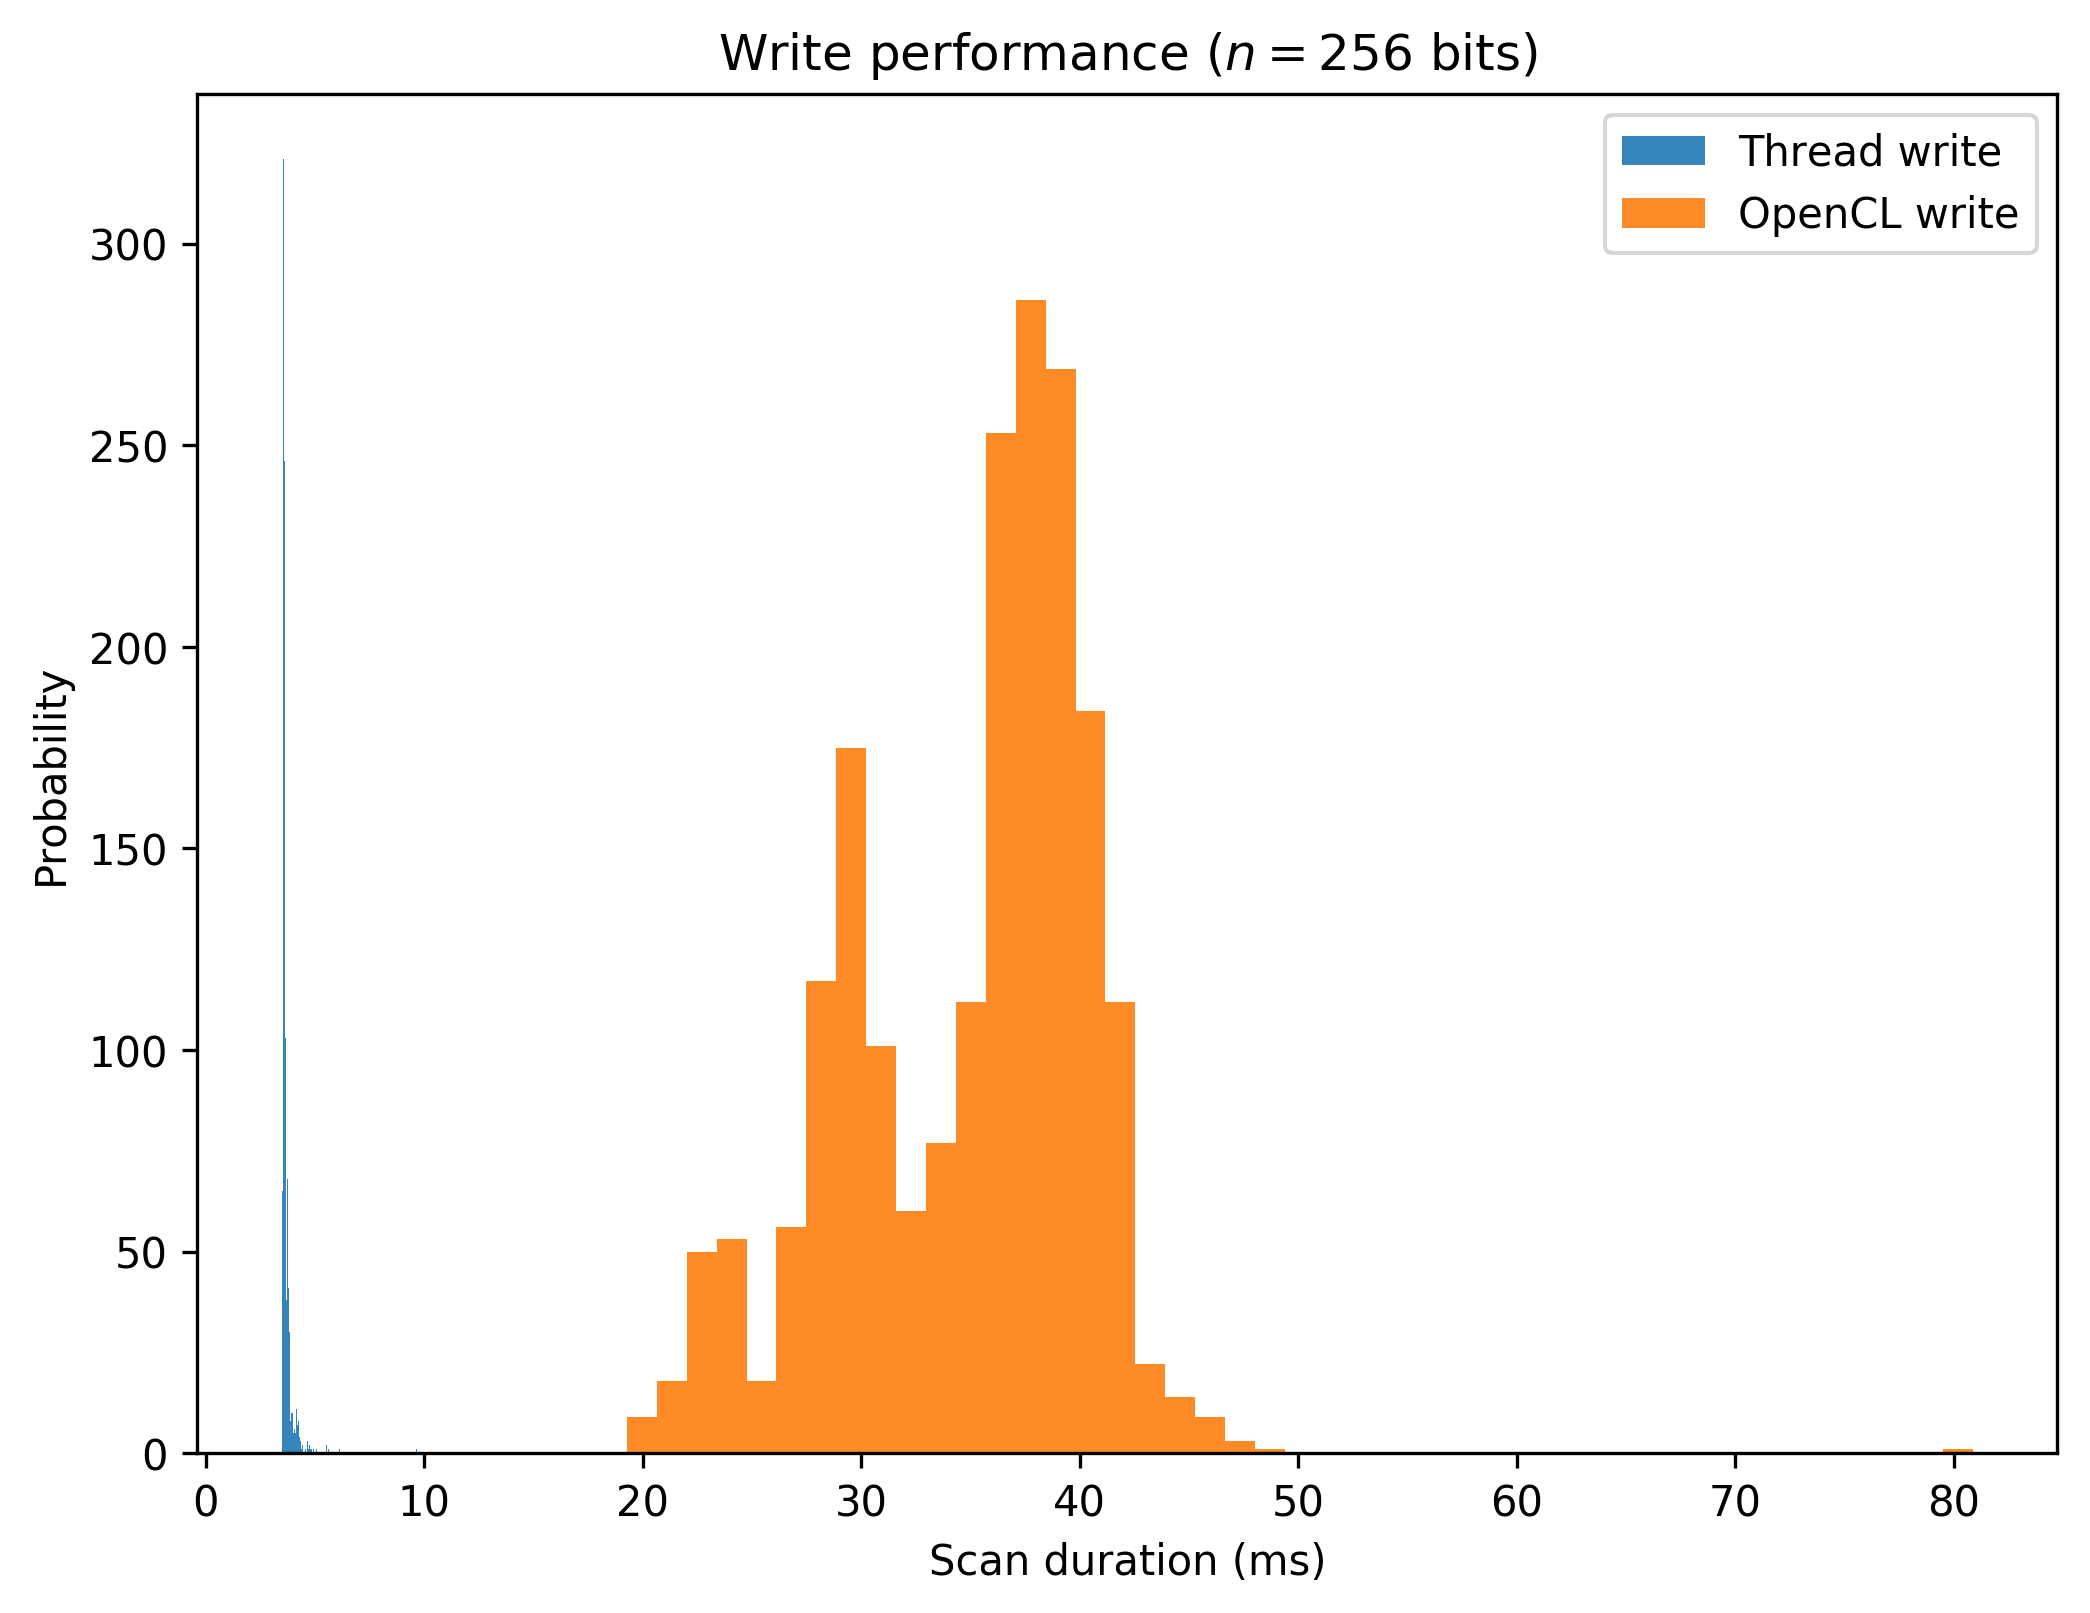

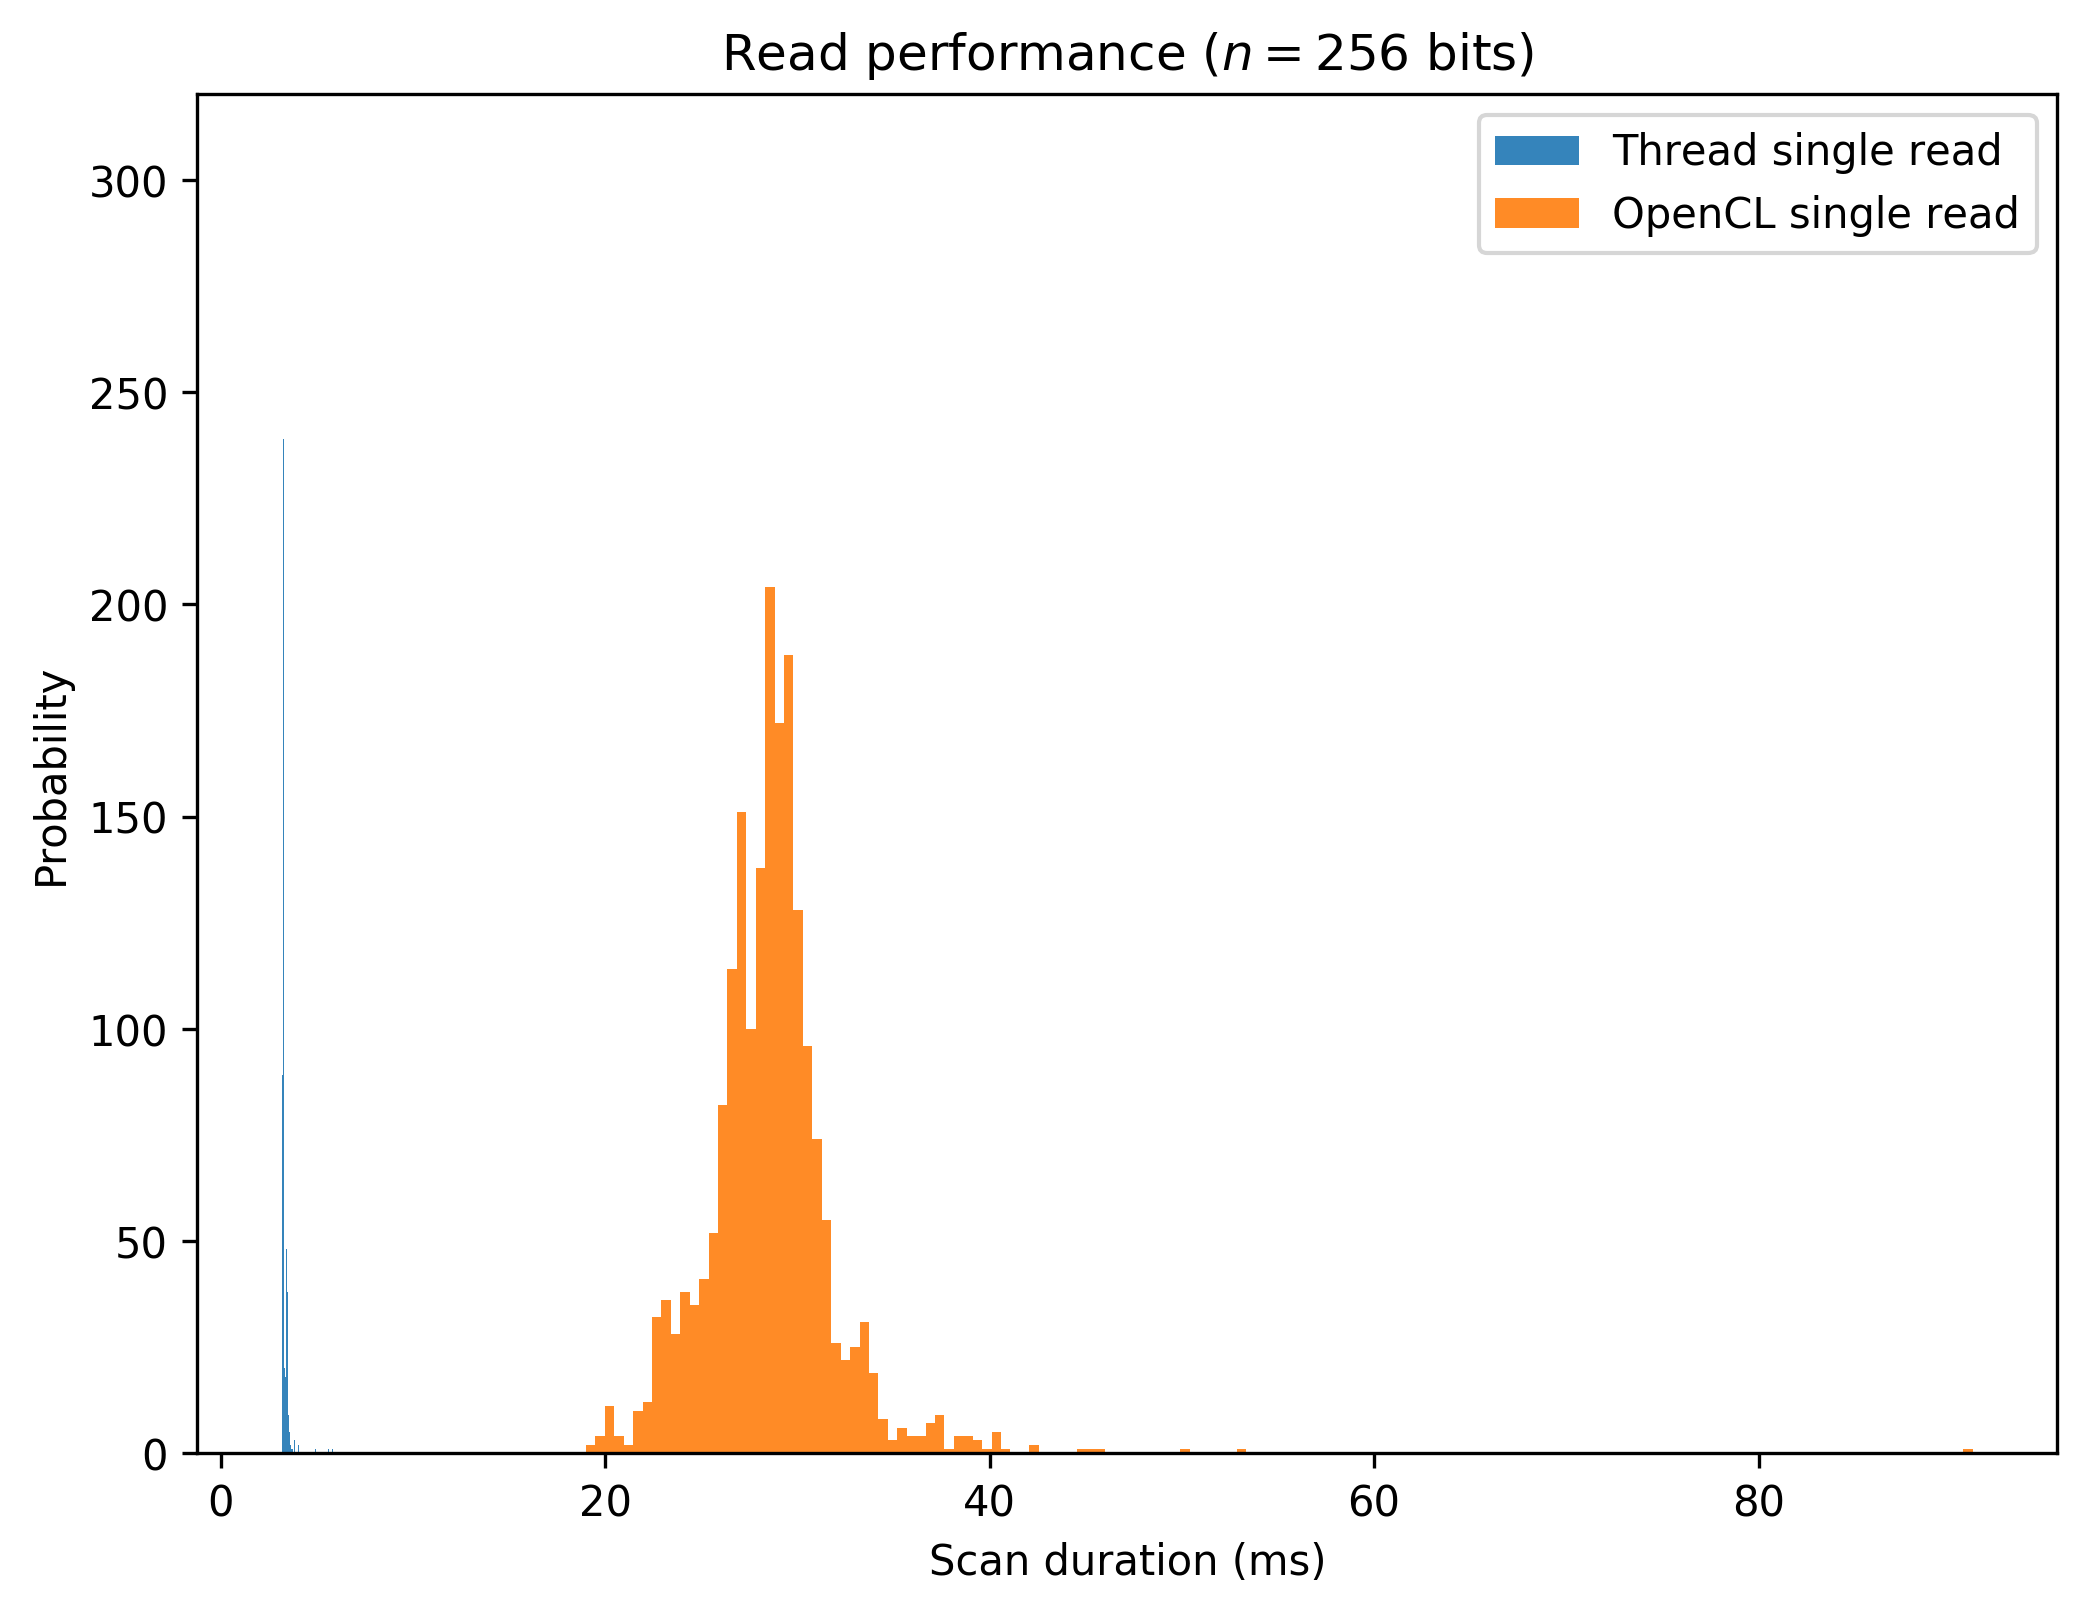

In [12]:
results_part2(256, p2timer256) #, hist_xlim=(0, 8))

In [16]:
#p2timer10k = run_part2(10000, 1000000, 4845, nthread=500, nopencl=1000)

In [20]:
#results_part2(10000, p2timer10k, hist1_xlim=(0, 8), hist2_xlim=(0, 8))

## Part 3 - Kernels comparison

In [21]:
def run_part3(bits, sample, radius, n=1000):
    address_space = sdmlib.AddressSpace.init_random(bits, sample)
    address_space.opencl_init()
    #address_space.opencl_opts.verbose = 1
    bs = sdmlib.Bitstring.init_random(bits)
    expected = set(address_space.scan_opencl2(bs, radius))
    
    timer = Timer()
    for kernel in sdmlib.OPENCL_KERNEL_NAMES:
        address_space.set_opencl_kernel(kernel)
        
        print('Running kernel {}...'.format(kernel))
        timer.start(kernel, kernel)
        for _ in range(n):
            address_space.scan_opencl2(bs, radius)
            timer.measure_loop()
        timer.end()
    return timer

In [25]:
def results_part3(bits, timer, hist_xlim=None):
    from IPython.display import display, Markdown
    v = [['', 'Loops', 'Total time', 'Scans per second', 'Time per scan (ms)']]
    v.append([':---', '---:', '---:', '---:', '---:'])
    for key in timer.stats.keys():
        stats = timer.stats[key]
        v.append([
            stats['name'],
            stats['number-of-loops'],
            stats['dt'],
            stats['loops-per-second'],
            1000.0 / stats['loops-per-second'],
        ])
    txt = '\n'.join(['|'.join([str(x) for x in row]) for row in v])
    display(Markdown(txt))
    
    plt.figure(figsize=(8, 6), dpi=300)
    for key in timer.stats.keys():
        stats = timer.stats[key]
        plt.hist([1000*x for x in stats['loops']], bins='fd', alpha=0.75, label=stats['name'])
    plt.legend()
    plt.title('Kernels performance ($n={}$ bits)'.format(bits))
    plt.xlabel('Scan duration (ms)')
    plt.ylabel('Probability')
    if hist_xlim:
        plt.xlim(*hist_xlim)
    plt.show()

In [23]:
p3timer1000 = run_part3(1000, 1000000, 451, n=3000)

Running kernel single_scan0...
Running kernel single_scan1...
Running kernel single_scan2...
Running kernel single_scan3...
Running kernel single_scan4...
Running kernel single_scan5...
Running kernel single_scan5_unroll...
Running kernel single_scan6...


|Loops|Total time|Scans per second|Time per scan (ms)
:---|---:|---:|---:|---:
single_scan0|3000|42.968416929244995|69.8187230155587|14.322805643081667
single_scan1|3000|43.97832107543945|68.21542811636364|14.659440358479817
single_scan2|3000|61.23765468597412|48.98946596475584|20.412551561991375
single_scan3|3000|54.271865129470825|55.27726001019511|18.09062170982361
single_scan4|3000|59.2001051902771|50.67558563211326|19.733368396759033
single_scan5|3000|54.47018504142761|55.07600162764883|18.156728347142536
single_scan5_unroll|3000|51.77652907371521|57.941311510643054|17.25884302457174
single_scan6|3000|56.399548053741455|53.191915600837596|18.799849351247154

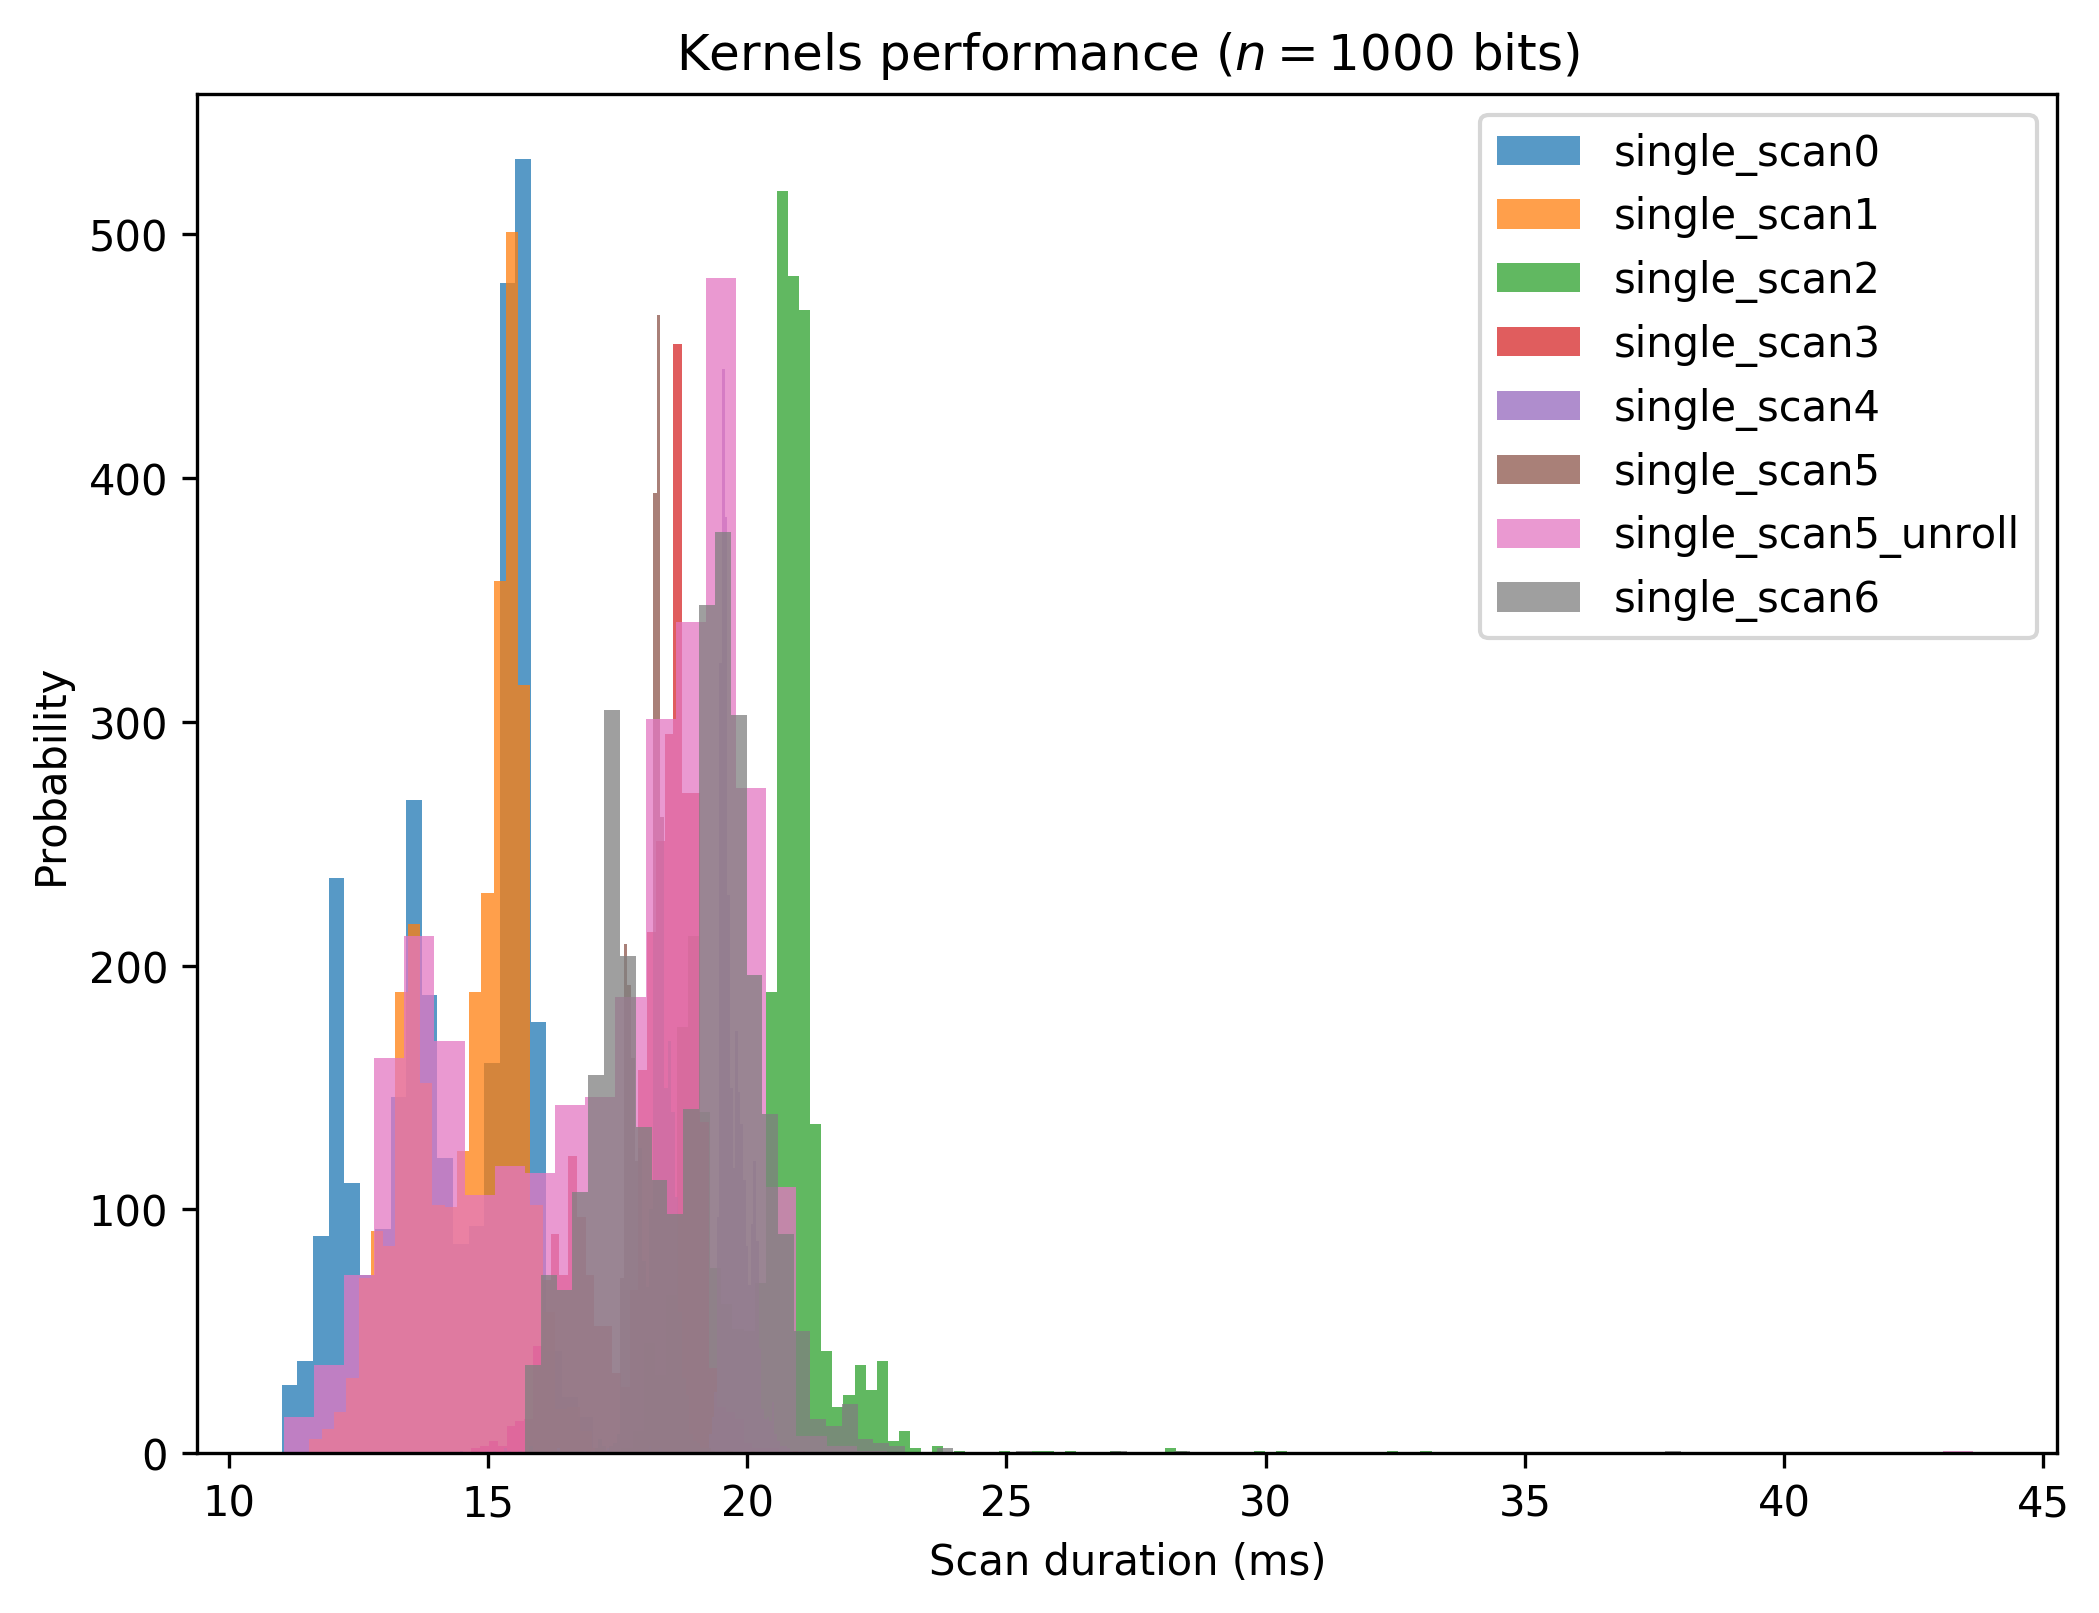

In [27]:
results_part3(1000, p3timer1000)#, hist_xlim=(2, 7))

In [28]:
p3timer256 = run_part3(256, 1000000, 103, n=3000)

Running kernel single_scan0...
Running kernel single_scan1...
Running kernel single_scan2...
Running kernel single_scan3...
Running kernel single_scan4...
Running kernel single_scan5...
Running kernel single_scan5_unroll...
Running kernel single_scan6...


|Loops|Total time|Scans per second|Time per scan (ms)
:---|---:|---:|---:|---:
single_scan0|3000|19.057180166244507|157.42098116455983|6.35239338874817
single_scan1|3000|19.385364055633545|154.75592779121297|6.461788018544515
single_scan2|3000|46.62026810646057|64.3496942820941|15.54008936882019
single_scan3|3000|52.75188994407654|56.87000035790883|17.58396331469218
single_scan4|3000|56.61430096626282|52.990144694849064|18.87143365542094
single_scan5|3000|51.72791314125061|57.99576703989706|17.242637713750202
single_scan5_unroll|3000|50.930001974105835|58.9043762756043|16.976667324701946
single_scan6|3000|55.769469022750854|53.792873638014484|18.589823007583618

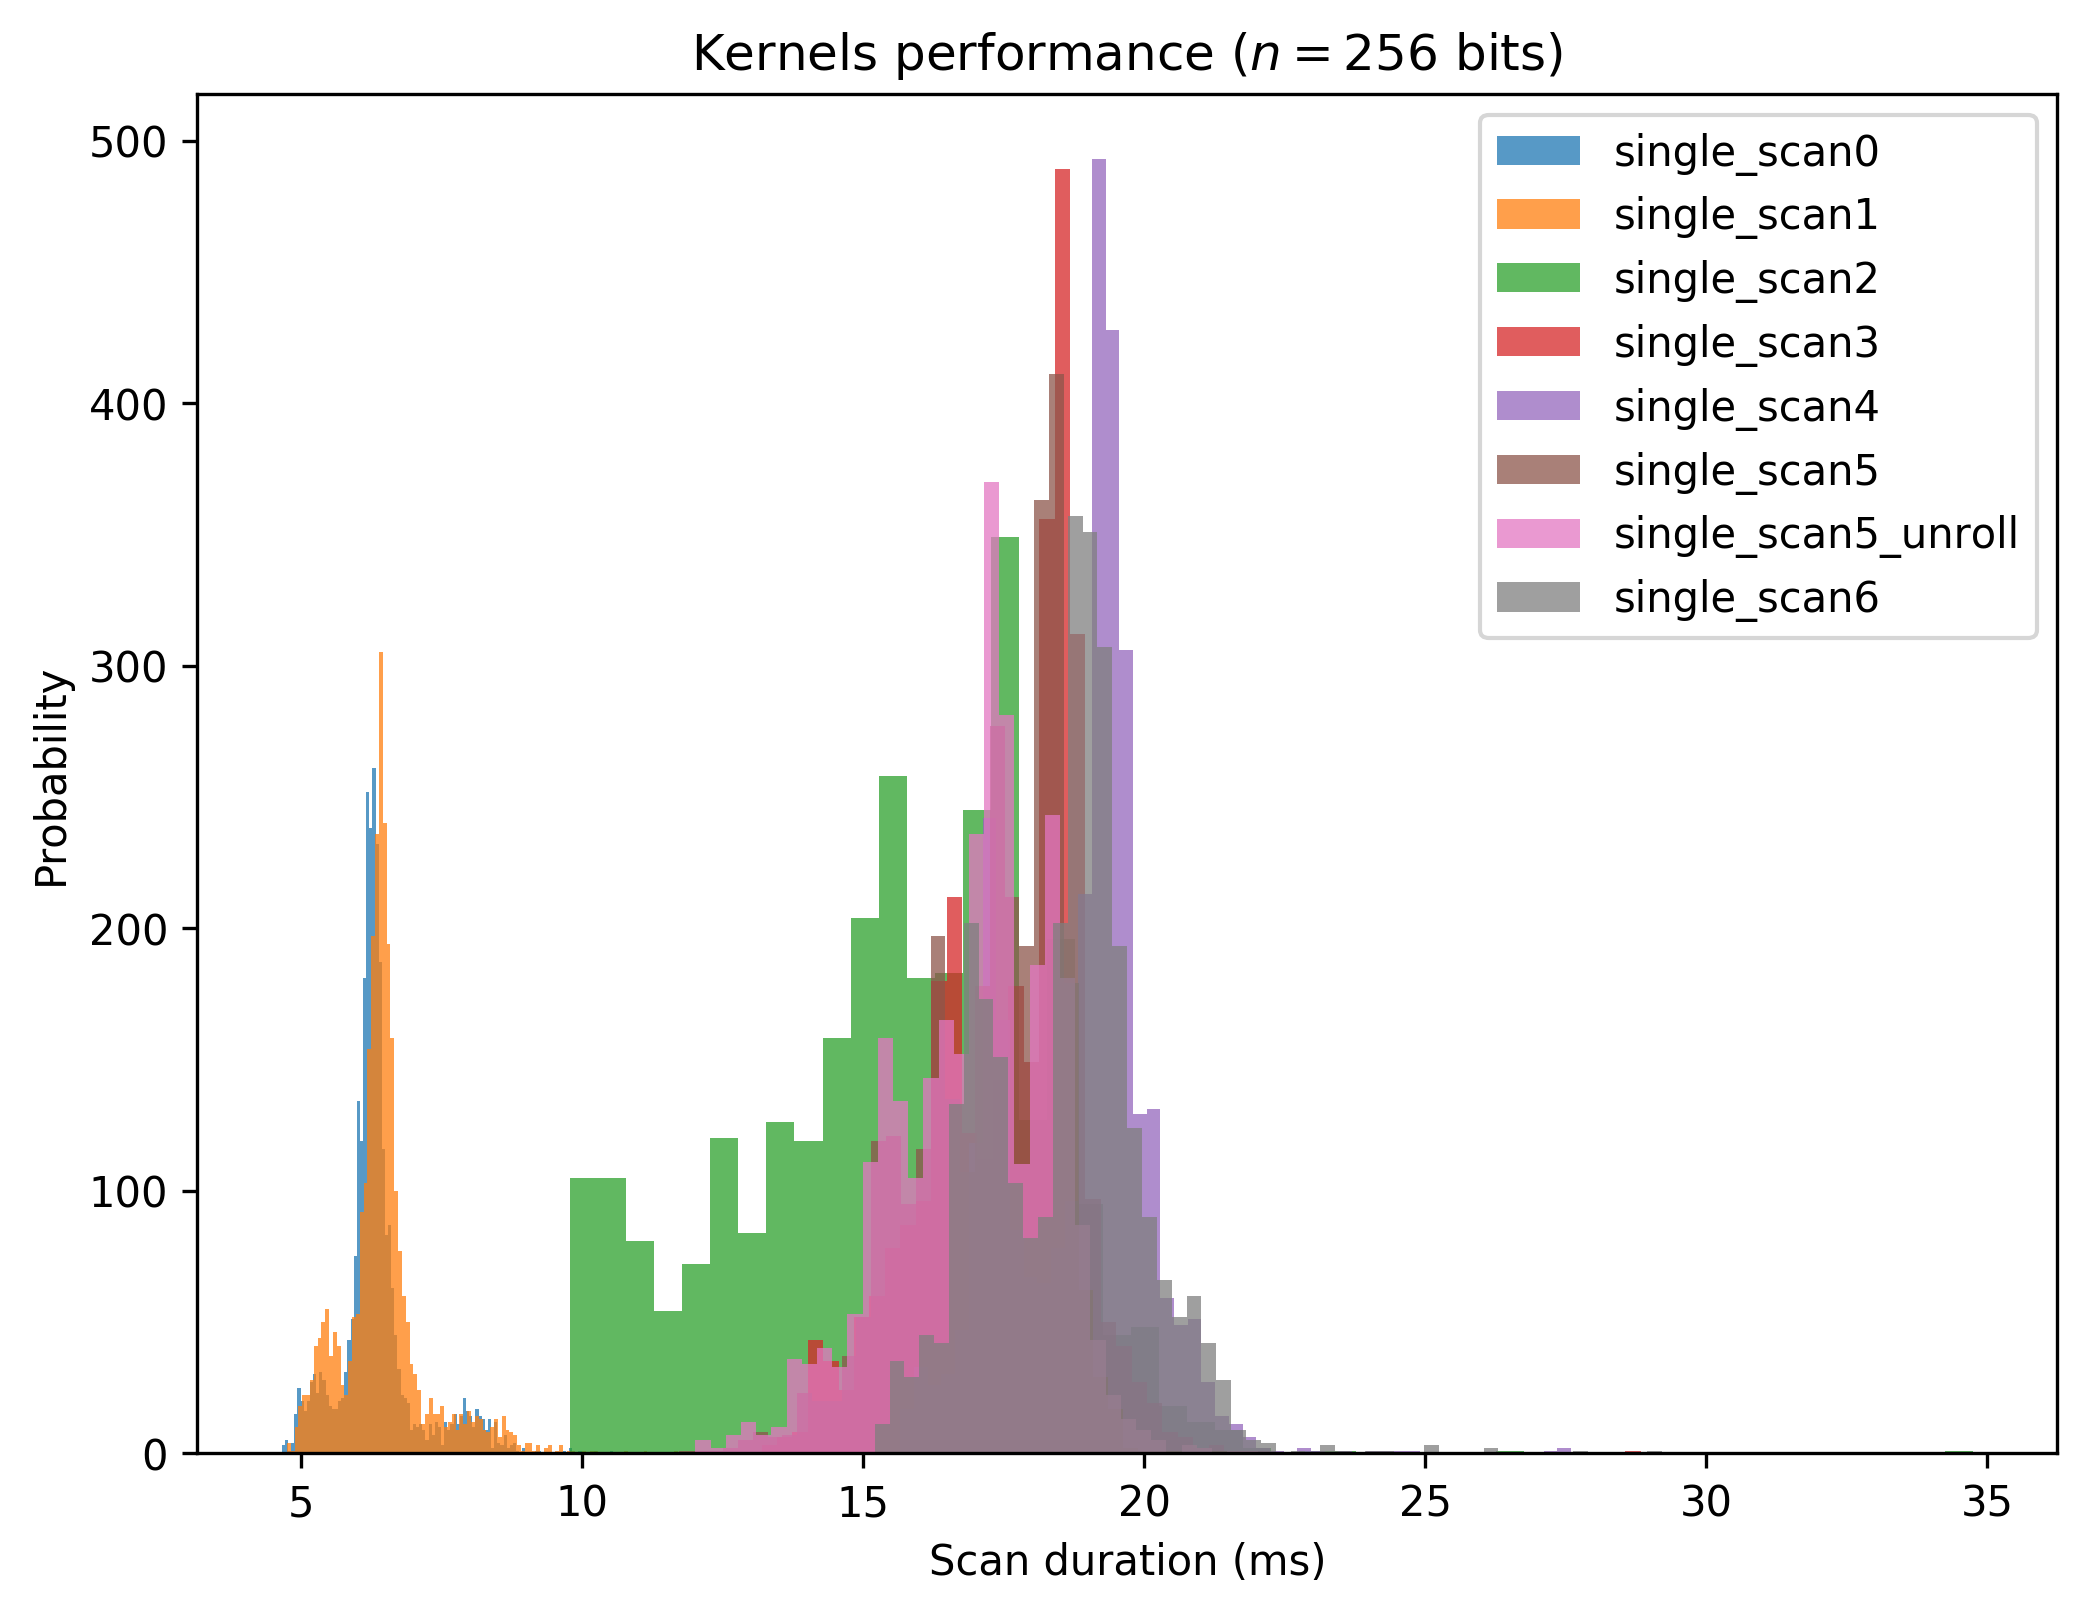

In [29]:
results_part3(256, p3timer256) #, hist_xlim=(2, 7))

In [76]:
p3timer10k = run_part3(10000, 1000000, 4845, n=500)

Running kernel single_scan0...
Running kernel single_scan1...
Running kernel single_scan2...
Running kernel single_scan3...
Running kernel single_scan4...
Running kernel single_scan5...
Running kernel single_scan5_unroll...
Running kernel single_scan6...


|Loops|Total time|Scans per second|Time per scan (ms)
:---|---:|---:|---:|---:
single_scan0|500|30.534967184066772|16.374669636484867|61.069934368133545
single_scan1|500|22.480546236038208|22.24145244293299|44.961092472076416
single_scan2|500|22.491918802261353|22.23020651976254|44.983837604522705
single_scan3|500|6.335015773773193|78.92640174156905|12.670031547546387
single_scan4|500|5.727261781692505|87.30175414685539|11.45452356338501
single_scan5|500|6.294461011886597|79.43491890025042|12.588922023773193
single_scan5_unroll|500|5.688975811004639|87.88928211521136|11.377951622009277
single_scan6|500|5.48170280456543|91.21253337258189|10.96340560913086

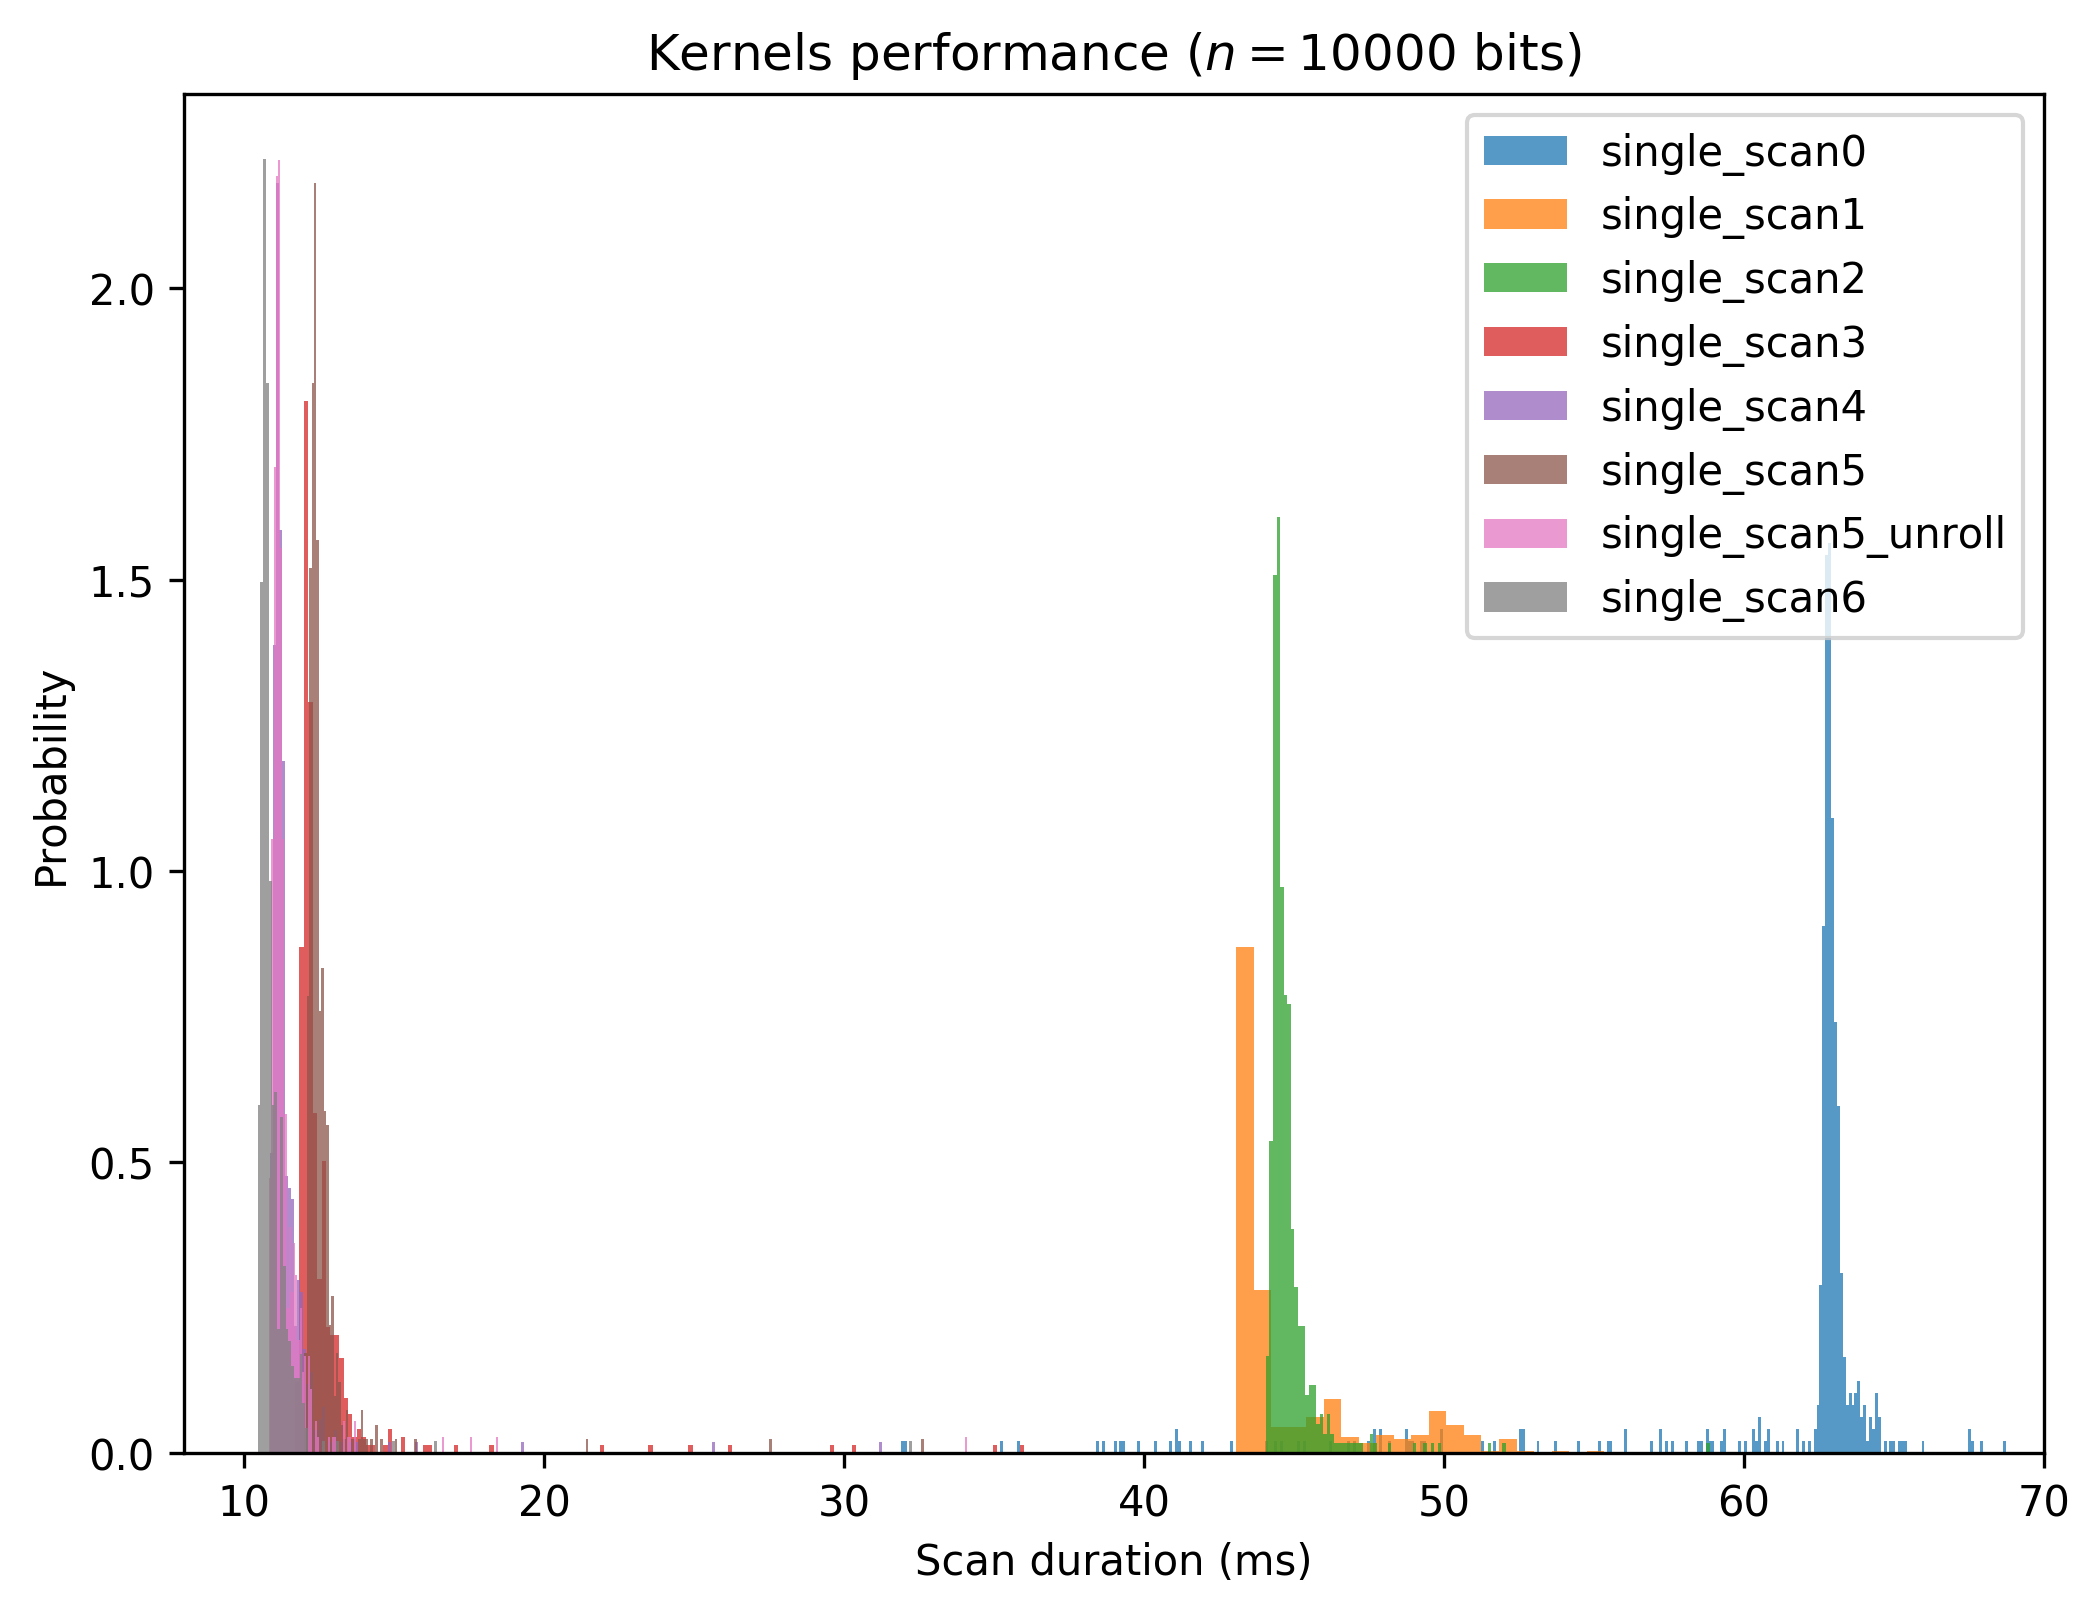

In [82]:
results_part3(10000, p3timer10k, hist_xlim=(8, 70))

|Loops|Total time|Scans per second|Time per scan (ms)
:---|---:|---:|---:|---:
single_scan0|500|30.534967184066772|16.374669636484867|61.069934368133545
single_scan1|500|22.480546236038208|22.24145244293299|44.961092472076416
single_scan2|500|22.491918802261353|22.23020651976254|44.983837604522705
single_scan3|500|6.335015773773193|78.92640174156905|12.670031547546387
single_scan4|500|5.727261781692505|87.30175414685539|11.45452356338501
single_scan5|500|6.294461011886597|79.43491890025042|12.588922023773193
single_scan5_unroll|500|5.688975811004639|87.88928211521136|11.377951622009277
single_scan6|500|5.48170280456543|91.21253337258189|10.96340560913086

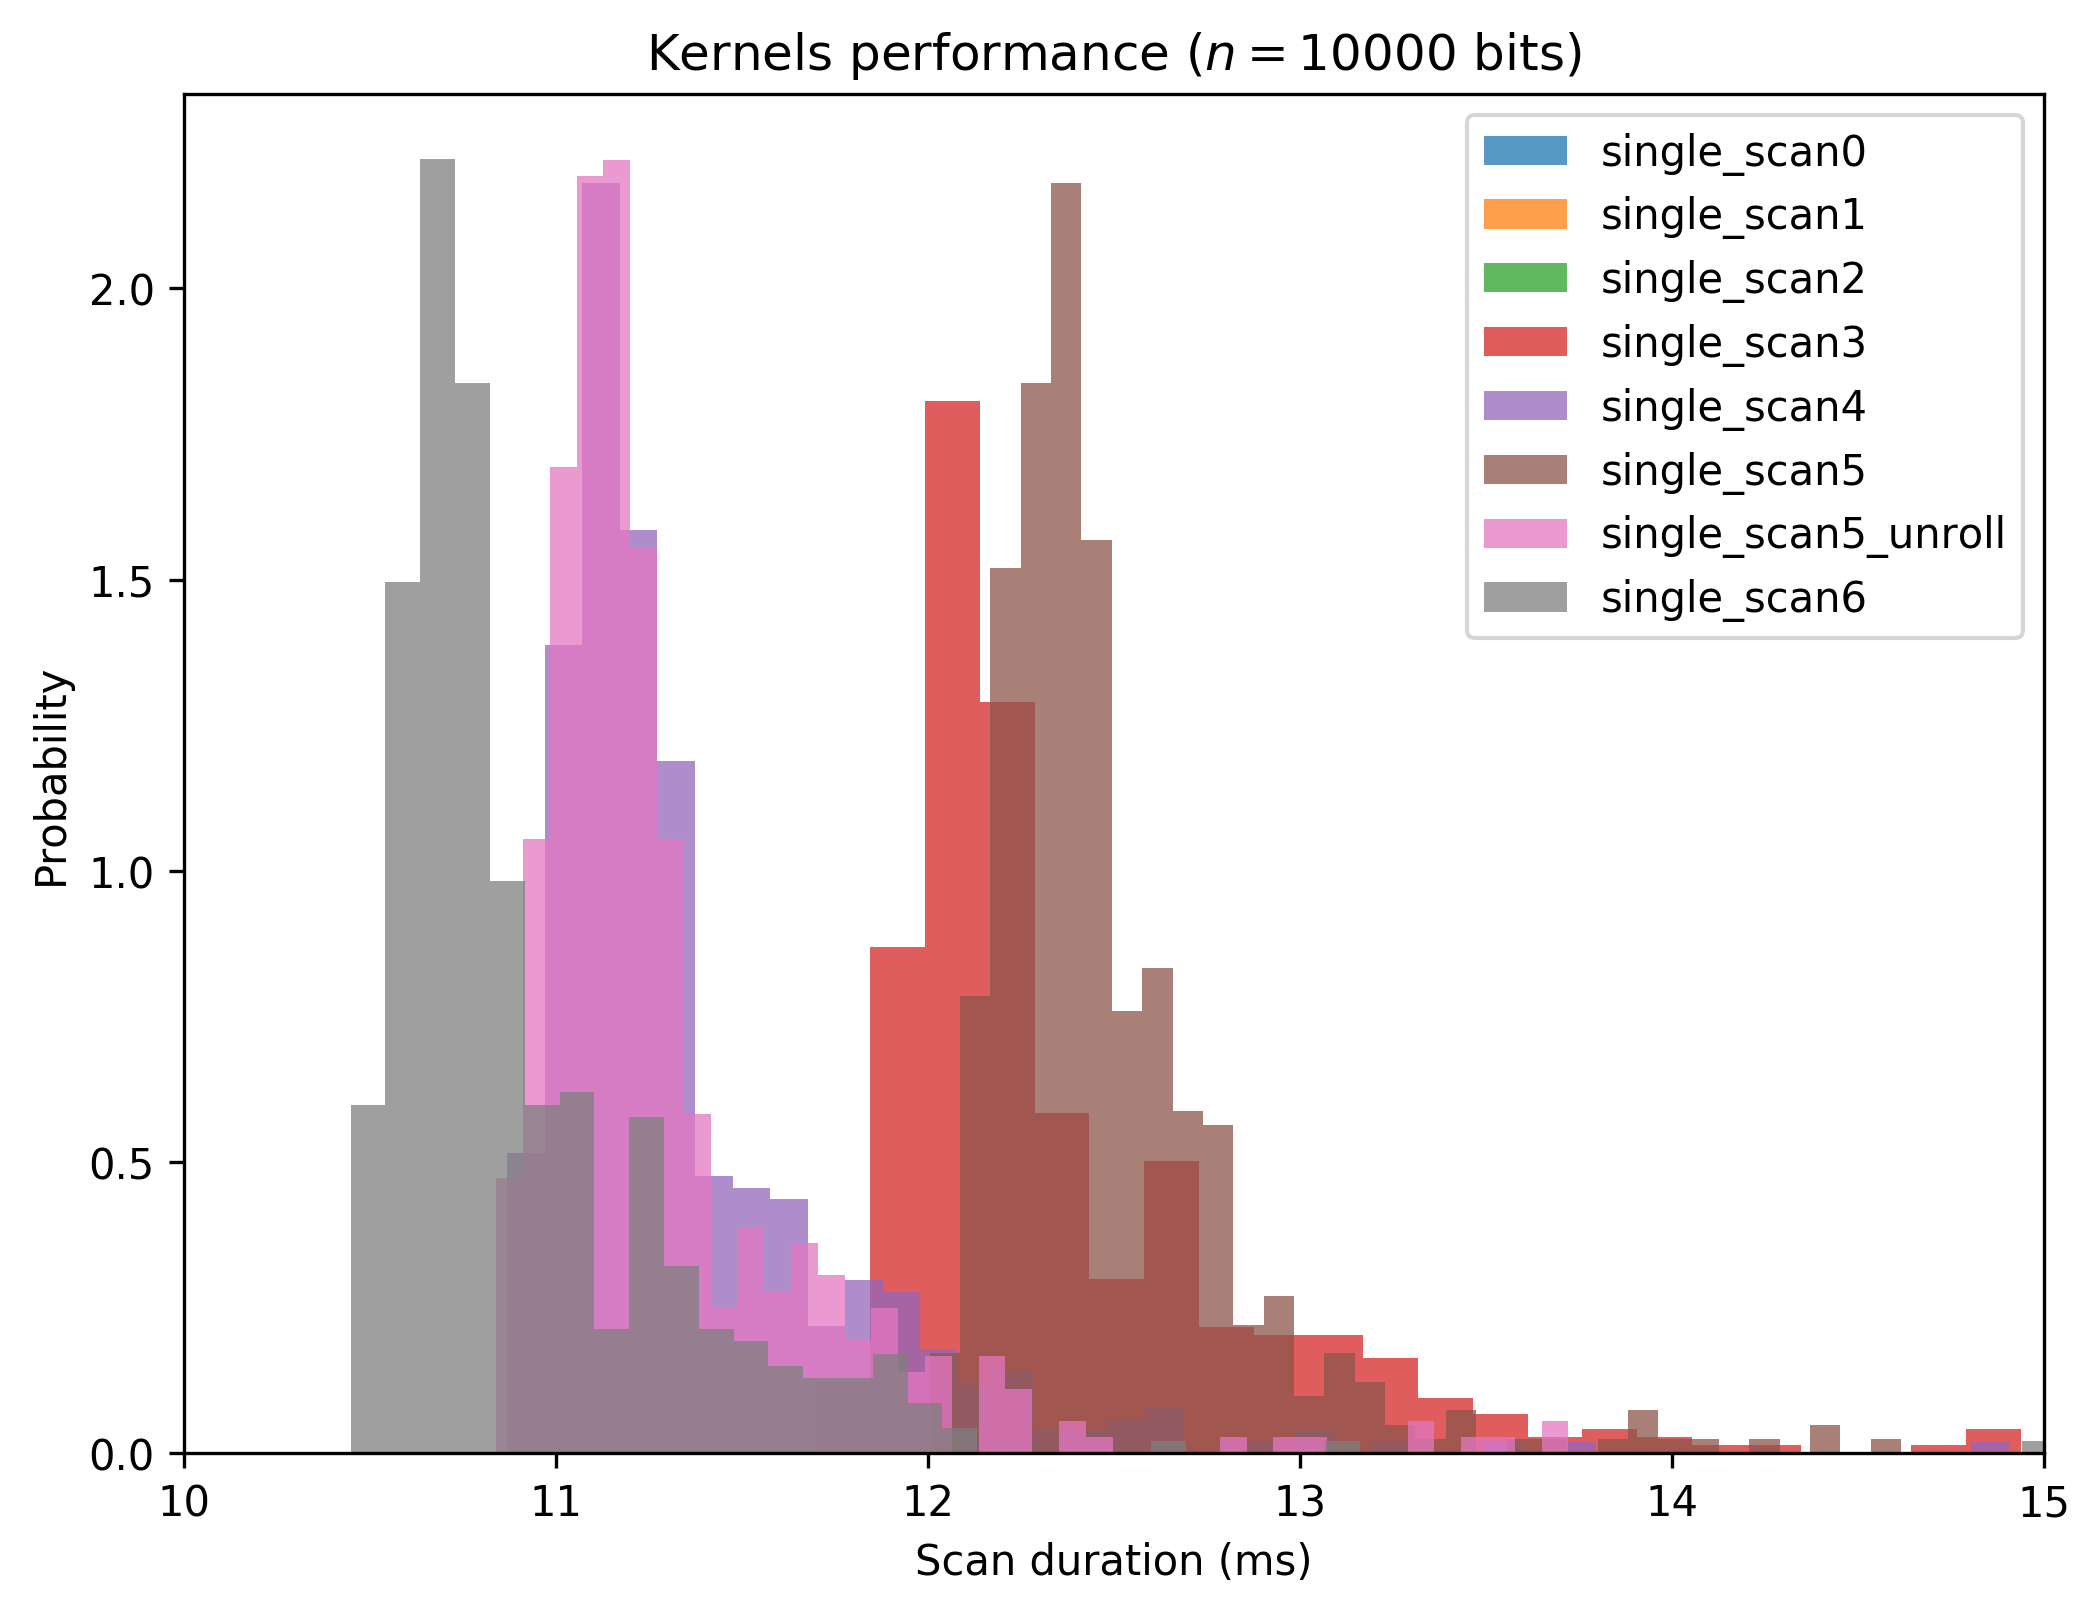

In [84]:
results_part3(10000, p3timer10k, hist_xlim=(10, 15))